# benchmark-figures

Lists of LLM calls I know of that should be measured:
1. LLM generation by the RAG (working)
2. Compression by the RAG (working)
3. Database selection by the DATABASE (working)
4. File selection by the UTILS/DATABASE (working)
5. Code selection by the SOFTWARE (working)
6. Code generation by the SOFTWARE (working)
7. LLM generation without the RAG (working)

# Read BRAD Log File

In [7]:
# normal
import os
import sys
import ast
import json
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch

In [8]:
experimentLogFile = "/home/jpic/RAG-DEV/tutorials/benchmark-search/2024-09-22_15-47-22/log.json"
with open(experimentLogFile) as f:
    logFile = json.load(f)

In [9]:
models = ['gpt-3.5-turbo-0125',
          'gpt-4o',
          'meta/llama3-70b-instruct',
          'meta/llama-3.1-405b-instruct',
          'mistralai/mistral-large-2-instruct',
          'nvidia/nemotron-4-340b-instruct',
          'google/gemma-2-9b-it'
         ]

filter_models = ['gpt-3.5-turbo-0125',
                 'gpt-4o'
                ]

In [76]:
# Create a DataFrame from the lists
log_df = pd.DataFrame({
    'Model'           : [], # LLM used
    'Module'          : [], # Module in BRAD
    'Total Time'      : [], # Total time for module
    'Parameters'      : [], # Parameters for module
    'Task'            : [], # Task/purpose in module
    'Task Time'       : [], # Time to complete single event
    'Input Tokens'    : [], # Number of input tokens
    'Output Tokens'   : [], # Number of output tokens
    'Total Tokens'    : [], # Number of total tokens
    'Task Cost (USD)' : [], # Cost in USD for individual llm call
    'Total Cost (USD)': [], # Cost in USD for full response to user
})

q = False

# Loop through the log file entries
for entry_key in logFile.keys():
    # print(entry_key)
    prompt_log = logFile[entry_key]
    prompt_log_str = str(prompt_log)

    # Find the model in the log entry
    log_model = next((m for m in models if m in prompt_log_str), None)
    if log_model is None:
        continue

    # Extract module information
    log_module = prompt_log['process']['module']
    log_total_time = prompt_log['elapsed time']

    log_list_models_list     = []
    log_list_modules_list    = []
    log_list_total_times     = []
    log_list_params_list     = []
    log_list_tasks_list      = []
    log_list_task_times      = []
    log_list_in_tokens       = []
    log_list_out_tokens      = []
    log_list_task_usd_costs  = []

    if log_module == 'DATABASE':
        for step in prompt_log['process']['steps']:
            log_params = "DATABASE"
            if 'llm' not in step.keys():
                continue
            elif step['purpose'] == 'Select database':
                output_dict = ast.literal_eval(prompt_log['process']['steps'][0]['output'])
                
                log_task_time  = output_dict['time']
                log_in_tokens  = output_dict['call back']['Prompt Tokens']
                log_out_tokens = output_dict['call back']['Completion Tokens']
                log_usd_cost   = output_dict['call back']['Total Cost (USD)']

                # Append data to the lists
                log_list_models_list.append(log_model)
                log_list_modules_list.append(log_module)
                log_list_total_times.append(log_total_time)
                log_list_params_list.append(log_params)
                log_list_tasks_list.append("Select database")
                log_list_task_times.append(log_task_time)
                log_list_in_tokens.append(log_in_tokens)
                log_list_out_tokens.append(log_out_tokens)
                log_list_task_usd_costs.append(log_usd_cost)
            elif step['purpose'] == 'Select File':
                output_dict = ast.literal_eval(prompt_log['process']['steps'][1]['output'].split("'call back': ")[-1][:-1])

                log_task_time  = float(prompt_log['process']['steps'][1]['output'].split("'time': ")[-1].split(',')[0])
                log_in_tokens  = output_dict['Prompt Tokens']
                log_out_tokens = output_dict['Completion Tokens']
                log_usd_cost   = output_dict['Total Cost (USD)']

                # Append data to the lists
                log_list_models_list.append(log_model)
                log_list_modules_list.append(log_module)
                log_list_total_times.append(log_total_time)
                log_list_params_list.append(log_params)
                log_list_tasks_list.append("Select file")
                log_list_task_times.append(log_task_time)
                log_list_in_tokens.append(log_in_tokens)
                log_list_out_tokens.append(log_out_tokens)
                log_list_task_usd_costs.append(log_usd_cost)
    
    # check if the module is code
    elif log_module == 'CODE':
        if len(prompt_log['process']['steps']) != 3:
            continue
        for step in prompt_log['process']['steps']:
            log_params = "SOFTWARE"
            if 'llm' not in step.keys():
                continue
            if step['purpose'] == 'Select which code to run':
                output_dict = ast.literal_eval("{" + step['output'].split("),")[-1])
                log_task_time  = output_dict['time']
                log_in_tokens  = output_dict['call back']['Prompt Tokens']
                log_out_tokens = output_dict['call back']['Completion Tokens']
                log_usd_cost   = output_dict['call back']['Total Cost (USD)']

                # Append data to the lists
                log_list_models_list.append(log_model)
                log_list_modules_list.append(log_module)
                log_list_total_times.append(log_total_time)
                log_list_params_list.append(log_params)
                log_list_tasks_list.append("Select code")
                log_list_task_times.append(log_task_time)
                log_list_in_tokens.append(log_in_tokens)
                log_list_out_tokens.append(log_out_tokens)
                log_list_task_usd_costs.append(log_usd_cost)
            if step['purpose'] == 'Format function call':
                output_dict = ast.literal_eval("{'time" + step['output'].split('time')[-1])
                log_task_time  = output_dict['time']
                log_in_tokens  = output_dict['call back']['Prompt Tokens']
                log_out_tokens = output_dict['call back']['Completion Tokens']
                log_usd_cost   = output_dict['call back']['Total Cost (USD)']

                # Append data to the lists
                log_list_models_list.append(log_model)
                log_list_modules_list.append(log_module)
                log_list_total_times.append(log_total_time)
                log_list_params_list.append(log_params)
                log_list_tasks_list.append("Call code")
                log_list_task_times.append(log_task_time)
                log_list_in_tokens.append(log_in_tokens)
                log_list_out_tokens.append(log_out_tokens)
                log_list_task_usd_costs.append(log_usd_cost)
    # Check if the module is 'RAG'
    elif log_module == 'RAG':
        log_params = 'RAG'
        
        for step in prompt_log['process']['steps']:
            # only check stages that use an LLM
            if 'llm' not in step.keys():
                continue

            # Check QA without RAG
            if 'purpose' in step.keys() and step['purpose'] == 'chat without RAG':
                # Set parameters for the step
                log_params = "No DB"
                
                # Extract task information
                output_dict = ast.literal_eval(step['output'])
                log_task_time  = output_dict['time']
                log_in_tokens  = output_dict['call back']['Prompt Tokens']
                log_out_tokens = output_dict['call back']['Completion Tokens']
                log_usd_cost   = output_dict['call back']['Total Cost (USD)']

                # Append data to the lists
                log_list_models_list.append(log_model)
                log_list_modules_list.append(log_module)
                log_list_total_times.append(log_total_time)
                log_list_params_list.append(log_params)
                log_list_tasks_list.append("QA")
                log_list_task_times.append(log_task_time)
                log_list_in_tokens.append(log_in_tokens)
                log_list_out_tokens.append(log_out_tokens)
                log_list_task_usd_costs.append(log_usd_cost)
                
            # Check QA with RAG
            elif 'purpose' in step.keys() and step['purpose'] == 'RAG':
                log_task_time  = ast.literal_eval(step['output'])['metadata']['time']
                log_in_tokens  = ast.literal_eval(step['output'])['metadata']['call back']['Prompt Tokens']
                log_out_tokens = ast.literal_eval(step['output'])['metadata']['call back']['Completion Tokens']
                log_usd_cost   = log_intokens = ast.literal_eval(step['output'])['metadata']['call back']['Total Cost (USD)']
                
                # Append data to the lists
                log_list_models_list.append(log_model)
                log_list_modules_list.append(log_module)
                log_list_total_times.append(log_total_time)
                log_list_params_list.append(log_params)
                log_list_tasks_list.append("QA (" + str(log_params) + ")")
                log_list_task_times.append(log_task_time)
                log_list_in_tokens.append(log_in_tokens)
                log_list_out_tokens.append(log_out_tokens)
                log_list_task_usd_costs.append(log_usd_cost)
                
            elif 'purpose' in step.keys() and step['purpose'] == 'contextual compression':
                log_params = "RAG, Compression"
                log_task_time  = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id=')[0])['time']
                log_in_tokens  = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id=')[0])['call back']['Prompt Tokens']
                log_out_tokens = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id=')[0])['call back']['Completion Tokens']
                log_usd_cost   = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id=')[0])['call back']['Total Cost (USD)']

                # Append data to the lists
                log_list_models_list.append(log_model)
                log_list_modules_list.append(log_module)
                log_list_total_times.append(log_total_time)
                log_list_params_list.append(log_params)
                log_list_tasks_list.append("Compression")
                log_list_task_times.append(log_task_time)
                log_list_in_tokens.append(log_in_tokens)
                log_list_out_tokens.append(log_out_tokens)
                log_list_task_usd_costs.append(log_usd_cost)

    # Build dataframe for this step
    single_log_df = pd.DataFrame({
        'Model'          : log_list_models_list,
        'Module'         : log_list_modules_list,
        'Total Time'     : log_list_total_times,
        'Parameters'     : log_list_params_list,
        'Task'           : log_list_tasks_list,
        'Task Time'      : log_list_task_times,
        'Input Tokens'   : log_list_in_tokens,
        'Output Tokens'  : log_list_out_tokens,
        'Task Cost (USD)': log_list_task_usd_costs
    })
    single_log_df['Total Tokens'] = single_log_df['Input Tokens'] + single_log_df['Output Tokens']
    single_log_df['Total Cost (USD)'] = single_log_df['Task Cost (USD)'].sum()

    log_df = pd.concat([log_df, single_log_df], ignore_index=True)
   

# Display the DataFrame
log_df = log_df[log_df['Model'].isin(filter_models)]
log_df.to_csv("/nfs/turbo/umms-indikar/shared/projects/RAG/dataInPaper/jpic_brad_profile.csv")
log_df


Model    Module  Total Time        Parameters  \
1    gpt-3.5-turbo-0125  DATABASE    2.055127          DATABASE   
2    gpt-3.5-turbo-0125  DATABASE    2.044675          DATABASE   
3    gpt-3.5-turbo-0125  DATABASE    1.943434          DATABASE   
4    gpt-3.5-turbo-0125  DATABASE    1.924876          DATABASE   
5    gpt-3.5-turbo-0125  DATABASE    2.357032          DATABASE   
..                  ...       ...         ...               ...   
825              gpt-4o       RAG   17.479515  RAG, Compression   
826              gpt-4o       RAG   17.479515  RAG, Compression   
827              gpt-4o       RAG   17.479515  RAG, Compression   
828              gpt-4o       RAG   17.479515  RAG, Compression   
829              gpt-4o       RAG   17.479515  RAG, Compression   

                      Task  Task Time  Input Tokens  Output Tokens  \
1          Select database   0.873842         427.0           51.0   
2          Select database   0.928157         429.0           51.0   
3          Select database   0.852115         427.0           51.0   
4          Select database   0.774714         427.0           52.0   
5          Select database   1.258245         425.0           50.0   
..                     ...        ...           ...            ...   
825            Compression   0.364309         403.0            1.0   
826            Compression   0.991231         463.0            1.0   
827            Compression   1.886669         367.0          115.0   
828            Compression   1.145913         391.0           71.0   
829  QA (RAG, Compression)   4.349958         841.0          366.0   

     Total Tokens  Task Cost (USD)  Total Cost (USD)  
1           478.0         0.000290          0.000290  
2           480.0         0.000291          0.000291  
3           478.0         0.000290          0.000290  
4           479.0         0.000291          0.000291  
5           475.0         0.000287          0.000287  
..            ...              ...               ...  
825         404.0         0.002030          0.038485  
826         464.0         0.002330          0.038485  
827         482.0         0.003560          0.038485  
828         462.0         0.003020          0.038485  
829        1207.0         0.009695          0.038485  

[829 rows x 11 columns]

# Figures

In [73]:
from matplotlib.patches import FancyBboxPatch

## Cost in USD

### Total costs

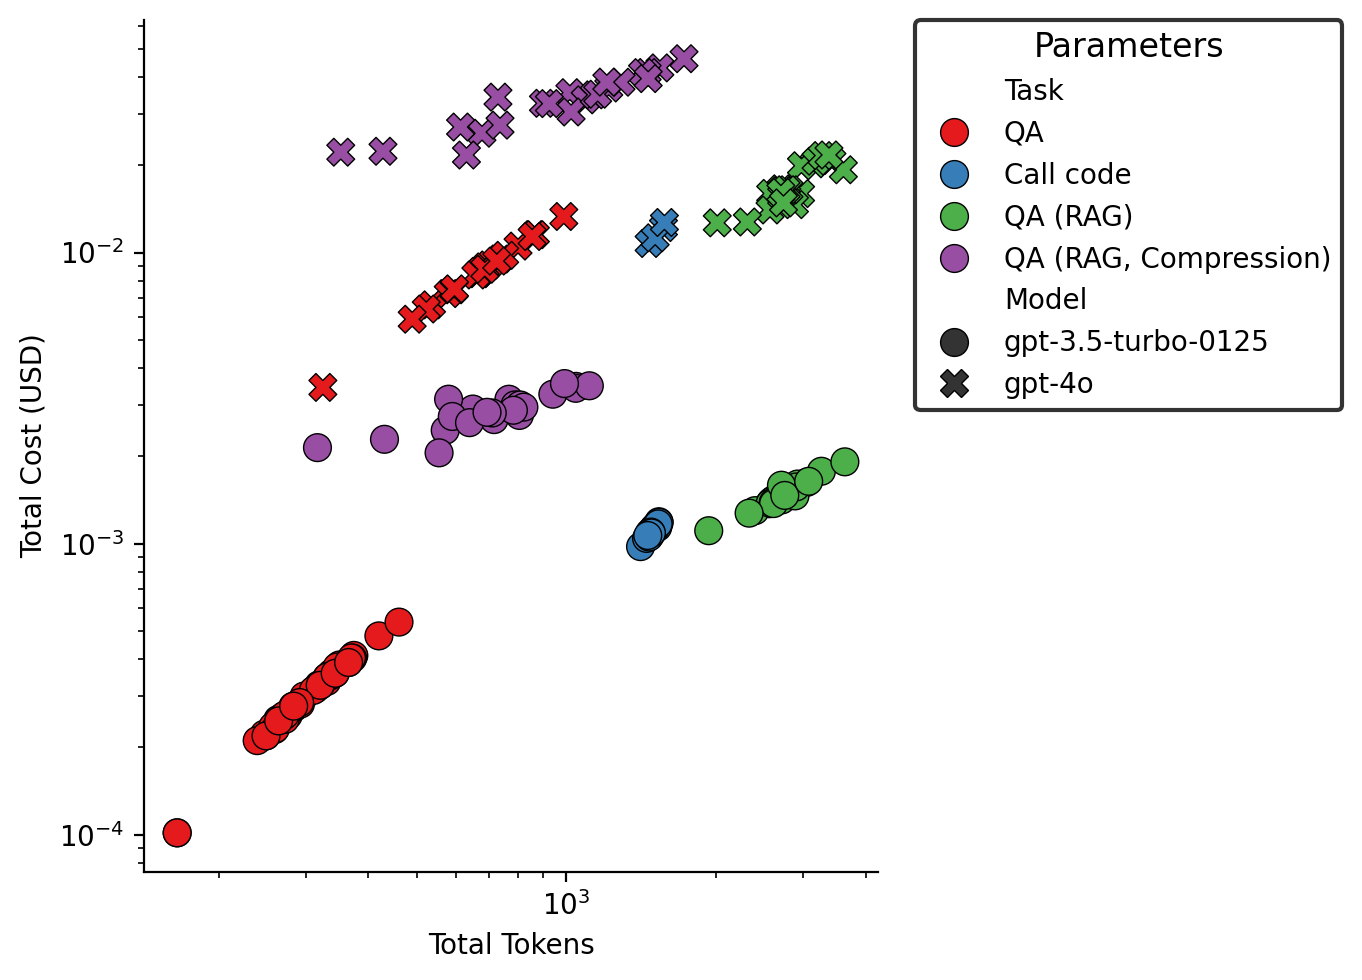

In [74]:
plt.figure(figsize=(7, 5), dpi=200)
scatter = sns.scatterplot(data=log_df[log_df['Task'].isin(['QA', 'QA (RAG)', 'QA (RAG, Compression)', 'Call code'])],
                          x='Total Tokens',
                          y='Total Cost (USD)',
                          style='Model',
                          hue='Task',
                          s=100,           # Set the marker size
                          palette='Set1',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

plt.yscale('log')
plt.xscale('log')

legend = plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', 
                    borderaxespad=0, fontsize=10, title_fontsize=12, frameon=True)
frame = legend.get_frame()
frame.set_linewidth(1.5)  # Set the thickness of the border
frame.set_edgecolor('black')  # Set border color
# frame.set_boxstyle(FancyBboxPatch("square", pad=0.1))  # Square corners

sns.despine()
plt.tight_layout()
plt.show()


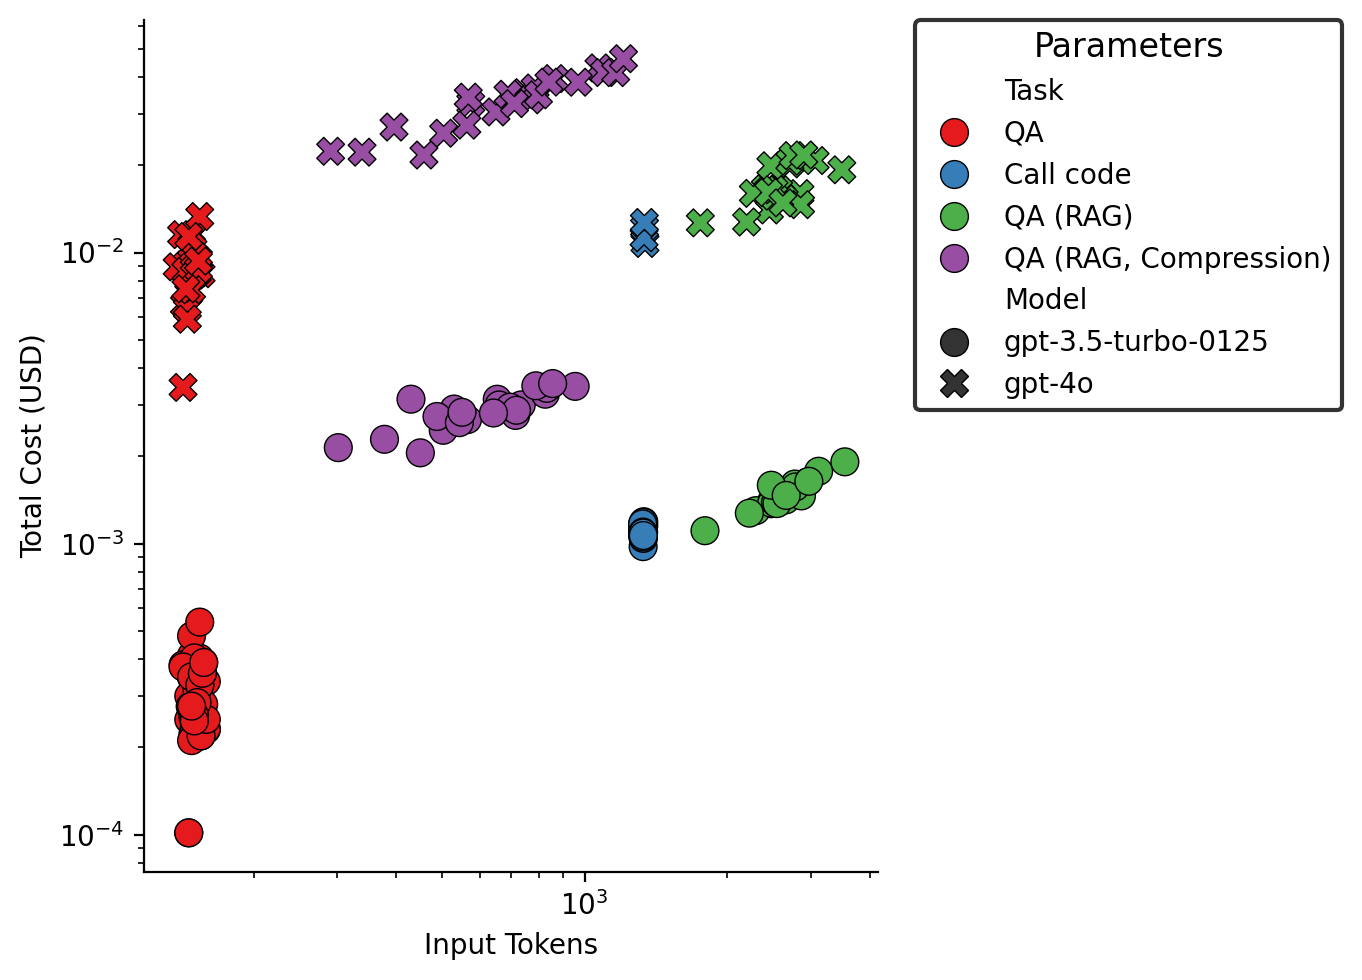

In [30]:
plt.figure(figsize=(7, 5), dpi=200)
scatter = sns.scatterplot(data=log_df[log_df['Task'].isin(['QA', 'QA (RAG)', 'QA (RAG, Compression)', 'Call code'])],
                          x='Input Tokens',
                          y='Total Cost (USD)',
                          style='Model',
                          hue='Task',
                          s=100,           # Set the marker size
                          palette='Set1',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

plt.yscale('log')
plt.xscale('log')

legend = plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', 
                    borderaxespad=0, fontsize=10, title_fontsize=12, frameon=True)
frame = legend.get_frame()
frame.set_linewidth(1.5)  # Set the thickness of the border
frame.set_edgecolor('black')  # Set border color
# frame.set_boxstyle(FancyBboxPatch("square", pad=0.1))  # Square corners

sns.despine()
plt.tight_layout()
plt.show()


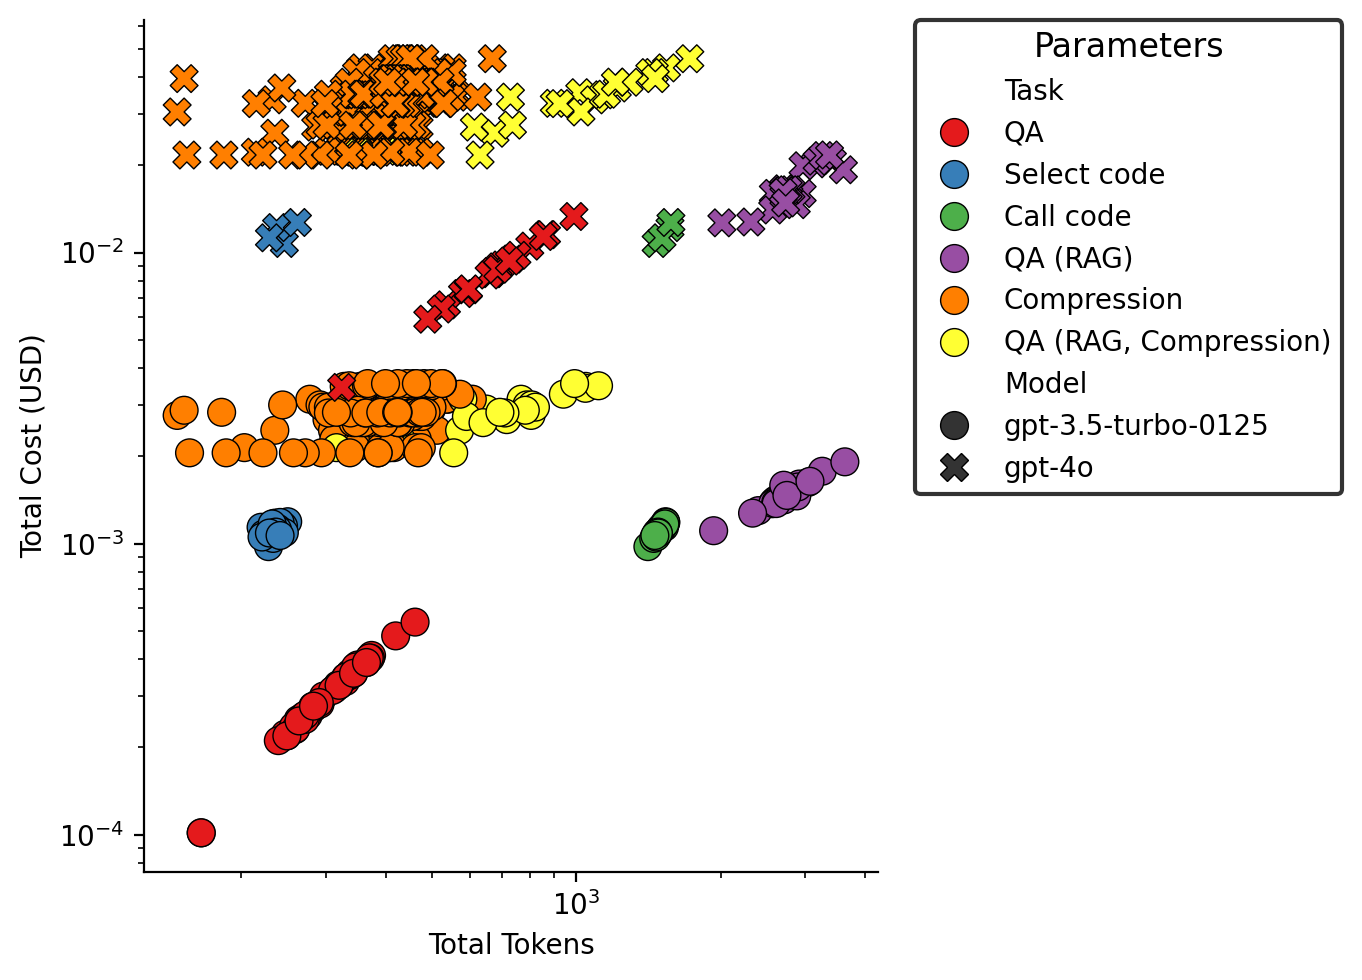

In [6]:
plt.figure(figsize=(7, 5), dpi=200)
scatter = sns.scatterplot(data=log_df,
                          x='Total Tokens',
                          y='Total Cost (USD)',
                          style='Model',
                          hue='Task',
                          s=100,           # Set the marker size
                          palette='Set1',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

plt.yscale('log')
plt.xscale('log')

legend = plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', 
                    borderaxespad=0, fontsize=10, title_fontsize=12, frameon=True)
frame = legend.get_frame()
frame.set_linewidth(1.5)  # Set the thickness of the border
frame.set_edgecolor('black')  # Set border color
# frame.set_boxstyle(FancyBboxPatch("square", pad=0.1))  # Square corners

sns.despine()
plt.tight_layout()
plt.show()


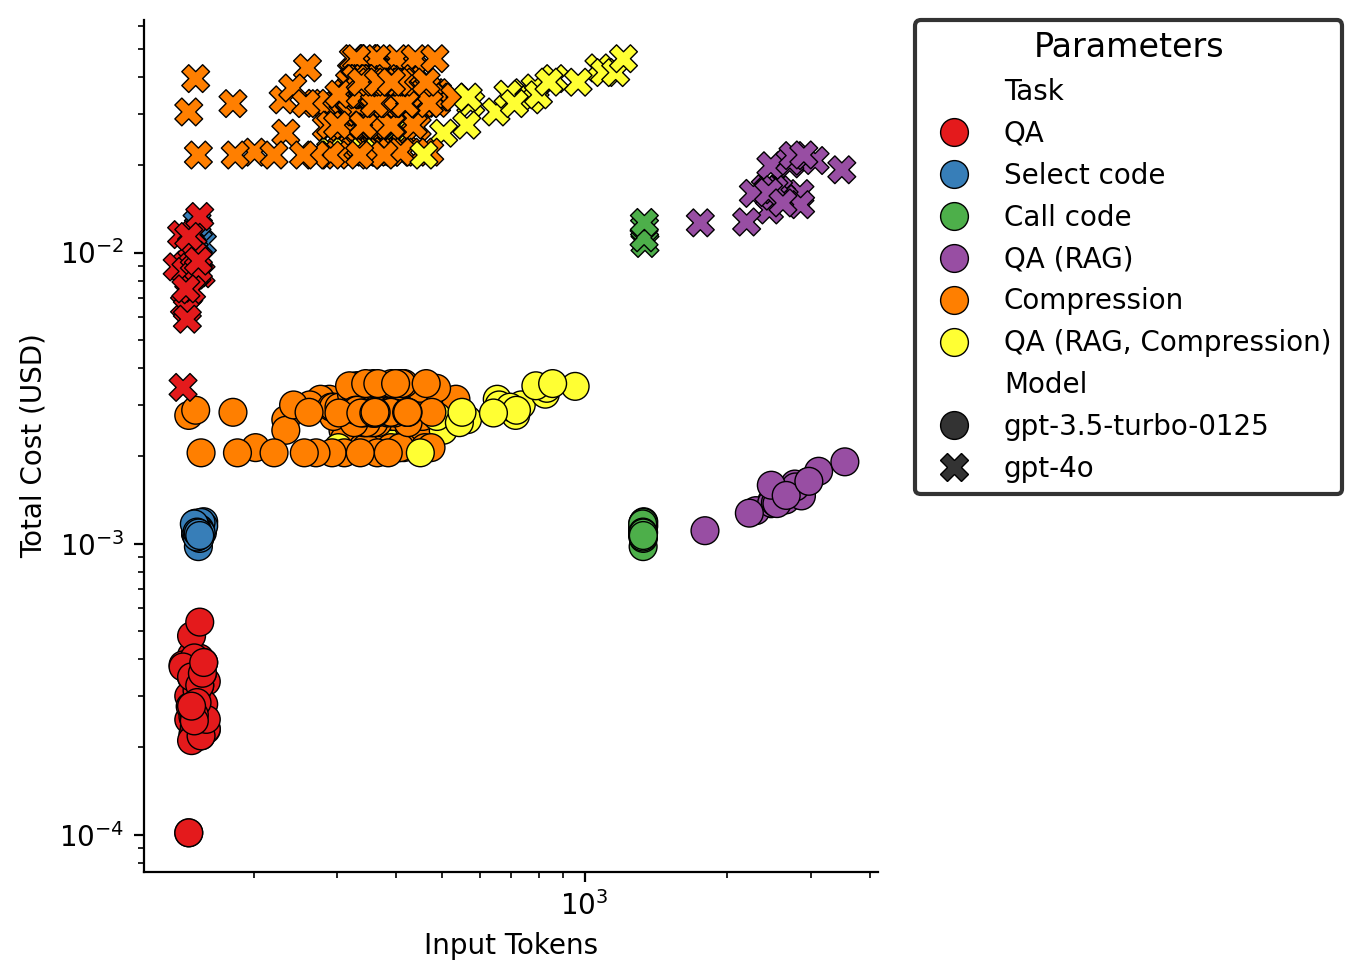

In [31]:
plt.figure(figsize=(7, 5), dpi=200)
scatter = sns.scatterplot(data=log_df,
                          x='Input Tokens',
                          y='Total Cost (USD)',
                          style='Model',
                          hue='Task',
                          s=100,           # Set the marker size
                          palette='Set1',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

plt.yscale('log')
plt.xscale('log')

legend = plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', 
                    borderaxespad=0, fontsize=10, title_fontsize=12, frameon=True)
frame = legend.get_frame()
frame.set_linewidth(1.5)  # Set the thickness of the border
frame.set_edgecolor('black')  # Set border color
# frame.set_boxstyle(FancyBboxPatch("square", pad=0.1))  # Square corners

sns.despine()
plt.tight_layout()
plt.show()


### Task Costs

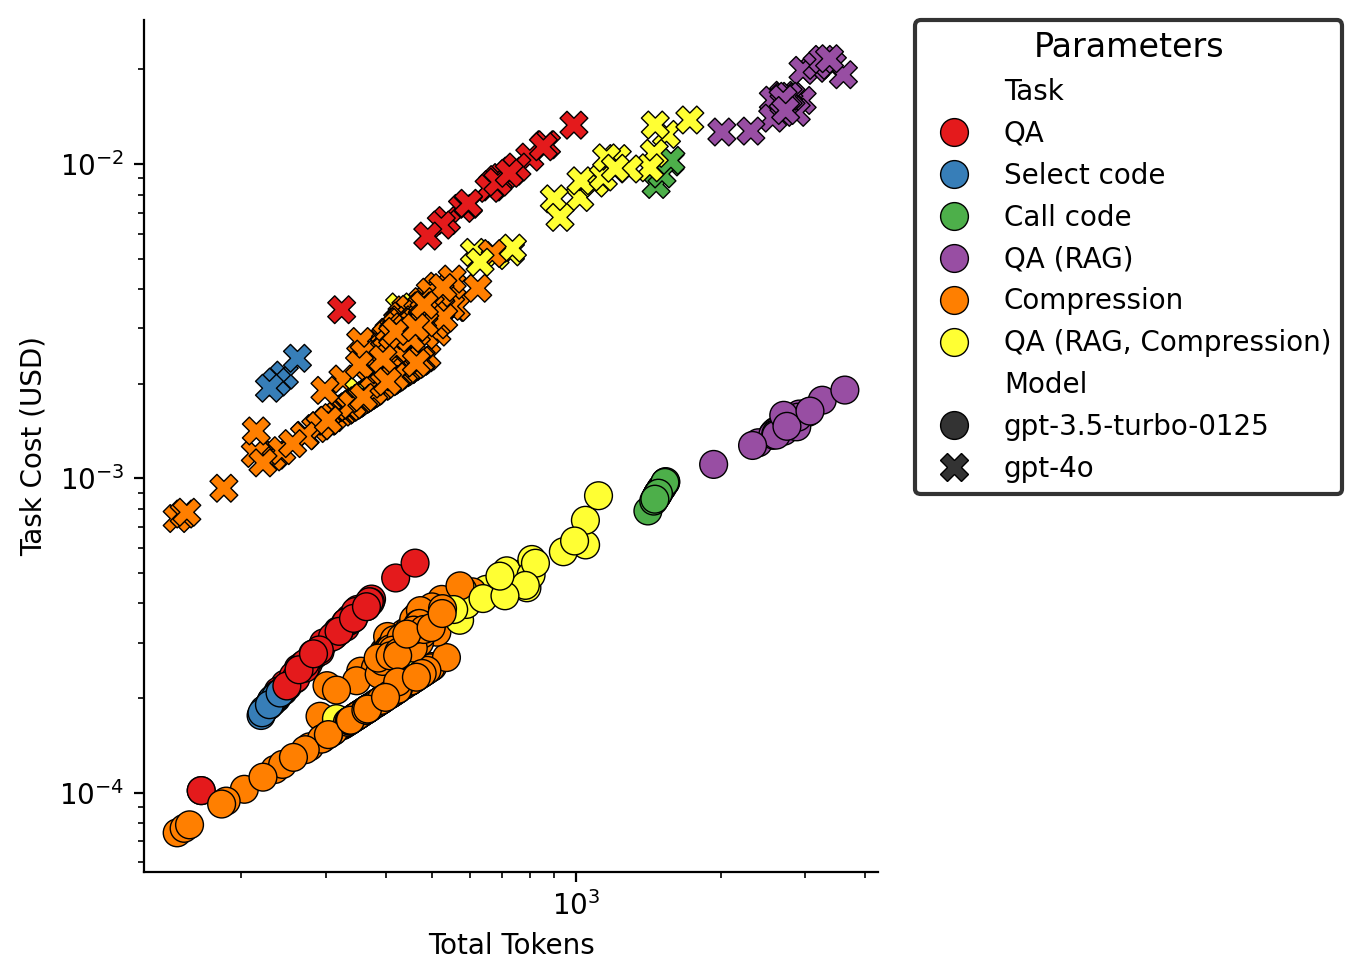

In [46]:
plt.figure(figsize=(7, 5), dpi=200)
scatter = sns.scatterplot(data=log_df,
                          x='Total Tokens',
                          y='Task Cost (USD)',
                          style='Model',
                          hue='Task',
                          s=100,           # Set the marker size
                          palette='Set1',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

plt.yscale('log')
plt.xscale('log')

legend = plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', 
                    borderaxespad=0, fontsize=10, title_fontsize=12, frameon=True)
frame = legend.get_frame()
frame.set_linewidth(1.5)  # Set the thickness of the border
frame.set_edgecolor('black')  # Set border color
# frame.set_boxstyle(FancyBboxPatch("square", pad=0.1))  # Square corners

sns.despine()
plt.tight_layout()
plt.show()


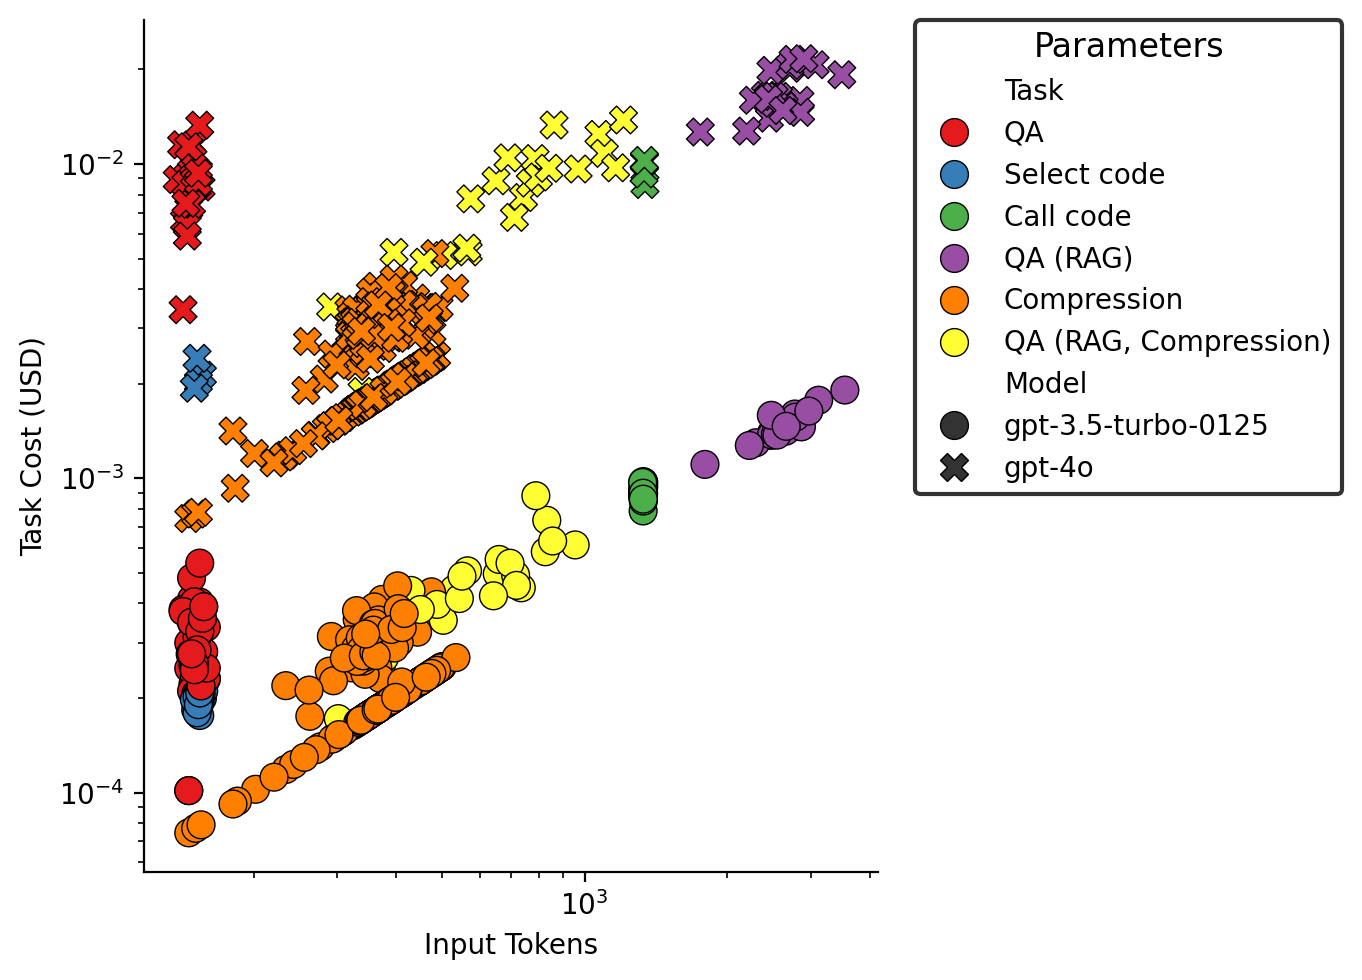

In [32]:
plt.figure(figsize=(7, 5), dpi=200)
scatter = sns.scatterplot(data=log_df,
                          x='Input Tokens',
                          y='Task Cost (USD)',
                          style='Model',
                          hue='Task',
                          s=100,           # Set the marker size
                          palette='Set1',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

plt.yscale('log')
plt.xscale('log')

legend = plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', 
                    borderaxespad=0, fontsize=10, title_fontsize=12, frameon=True)
frame = legend.get_frame()
frame.set_linewidth(1.5)  # Set the thickness of the border
frame.set_edgecolor('black')  # Set border color
# frame.set_boxstyle(FancyBboxPatch("square", pad=0.1))  # Square corners

sns.despine()
plt.tight_layout()
plt.show()


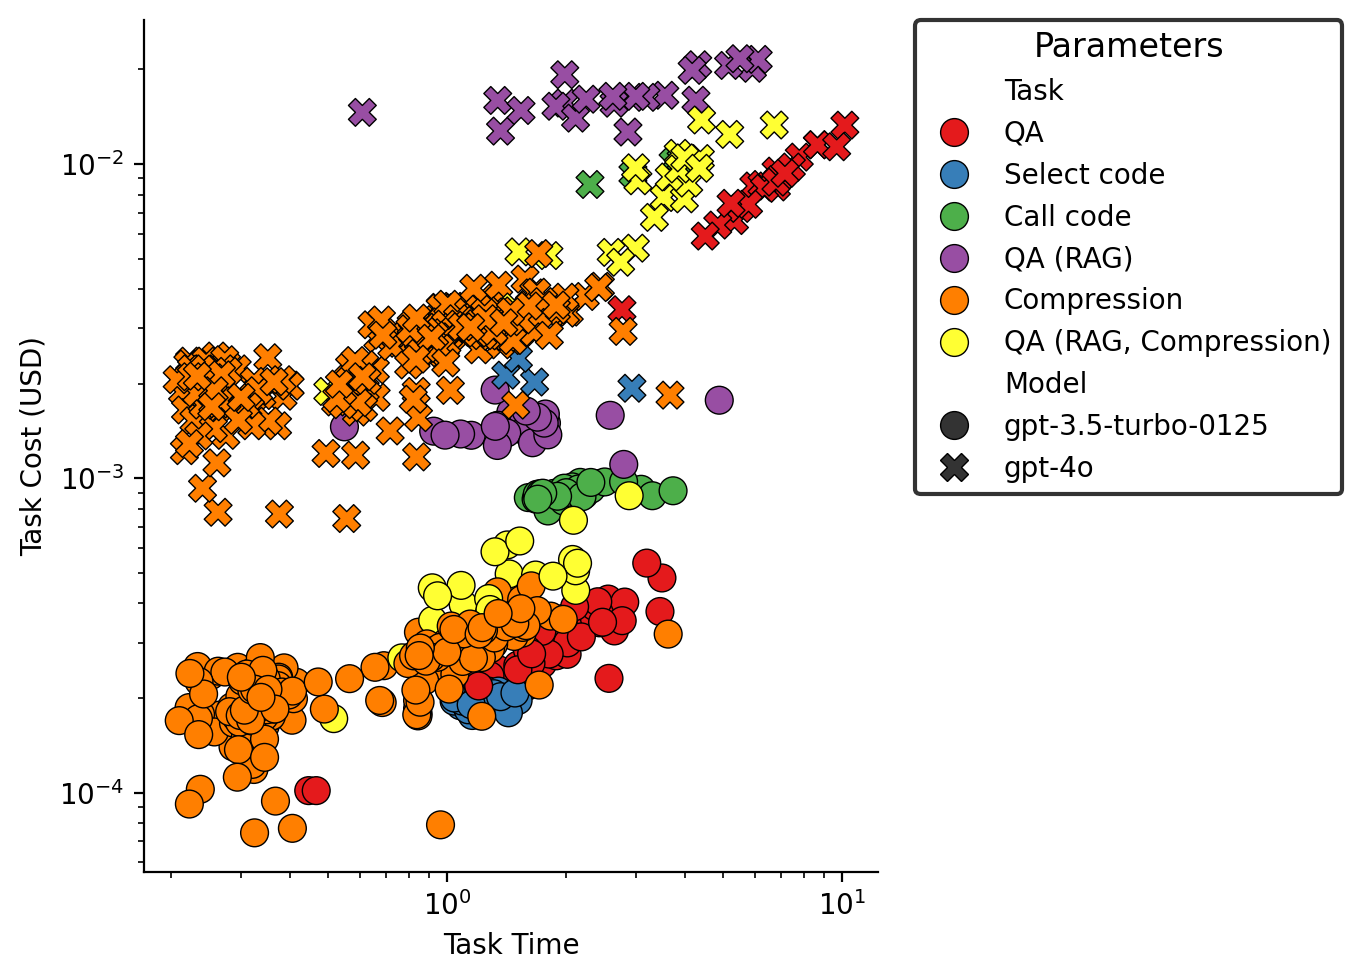

In [33]:
plt.figure(figsize=(7, 5), dpi=200)
scatter = sns.scatterplot(data=log_df,
                          x='Task Time',
                          y='Task Cost (USD)',
                          style='Model',
                          hue='Task',
                          s=100,           # Set the marker size
                          palette='Set1',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

plt.yscale('log')
plt.xscale('log')

legend = plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', 
                    borderaxespad=0, fontsize=10, title_fontsize=12, frameon=True)
frame = legend.get_frame()
frame.set_linewidth(1.5)  # Set the thickness of the border
frame.set_edgecolor('black')  # Set border color
# frame.set_boxstyle(FancyBboxPatch("square", pad=0.1))  # Square corners

sns.despine()
plt.tight_layout()
plt.show()


In [47]:
log_df

Model Module  Total Time        Parameters  \
1    gpt-3.5-turbo-0125    RAG    1.510716             No DB   
2    gpt-3.5-turbo-0125    RAG    2.000100             No DB   
3    gpt-3.5-turbo-0125    RAG    2.156716             No DB   
4    gpt-3.5-turbo-0125    RAG    2.555365             No DB   
5    gpt-3.5-turbo-0125    RAG    2.650423             No DB   
..                  ...    ...         ...               ...   
654              gpt-4o    RAG   17.479515  RAG, Compression   
655              gpt-4o    RAG   17.479515  RAG, Compression   
656              gpt-4o    RAG   17.479515  RAG, Compression   
657              gpt-4o    RAG   17.479515  RAG, Compression   
658              gpt-4o    RAG   17.479515  RAG, Compression   

                      Task  Task Time  Input Tokens  Output Tokens  \
1                       QA   1.508574         146.0          117.0   
2                       QA   1.996054         147.0          190.0   
3                       QA   2.155040         159.0          171.0   
4                       QA   2.553845         148.0          226.0   
5                       QA   2.648648         150.0          168.0   
..                     ...        ...           ...            ...   
654            Compression   0.364309         403.0            1.0   
655            Compression   0.991231         463.0            1.0   
656            Compression   1.886669         367.0          115.0   
657            Compression   1.145913         391.0           71.0   
658  QA (RAG, Compression)   4.349958         841.0          366.0   

     Total Tokens  Task Cost (USD)  Total Cost (USD)  
1           263.0         0.000249          0.000249  
2           337.0         0.000358          0.000358  
3           330.0         0.000336          0.000336  
4           374.0         0.000413          0.000413  
5           318.0         0.000327          0.000327  
..            ...              ...               ...  
654         404.0         0.002030          0.038485  
655         464.0         0.002330          0.038485  
656         482.0         0.003560          0.038485  
657         462.0         0.003020          0.038485  
658        1207.0         0.009695          0.038485  

[658 rows x 11 columns]

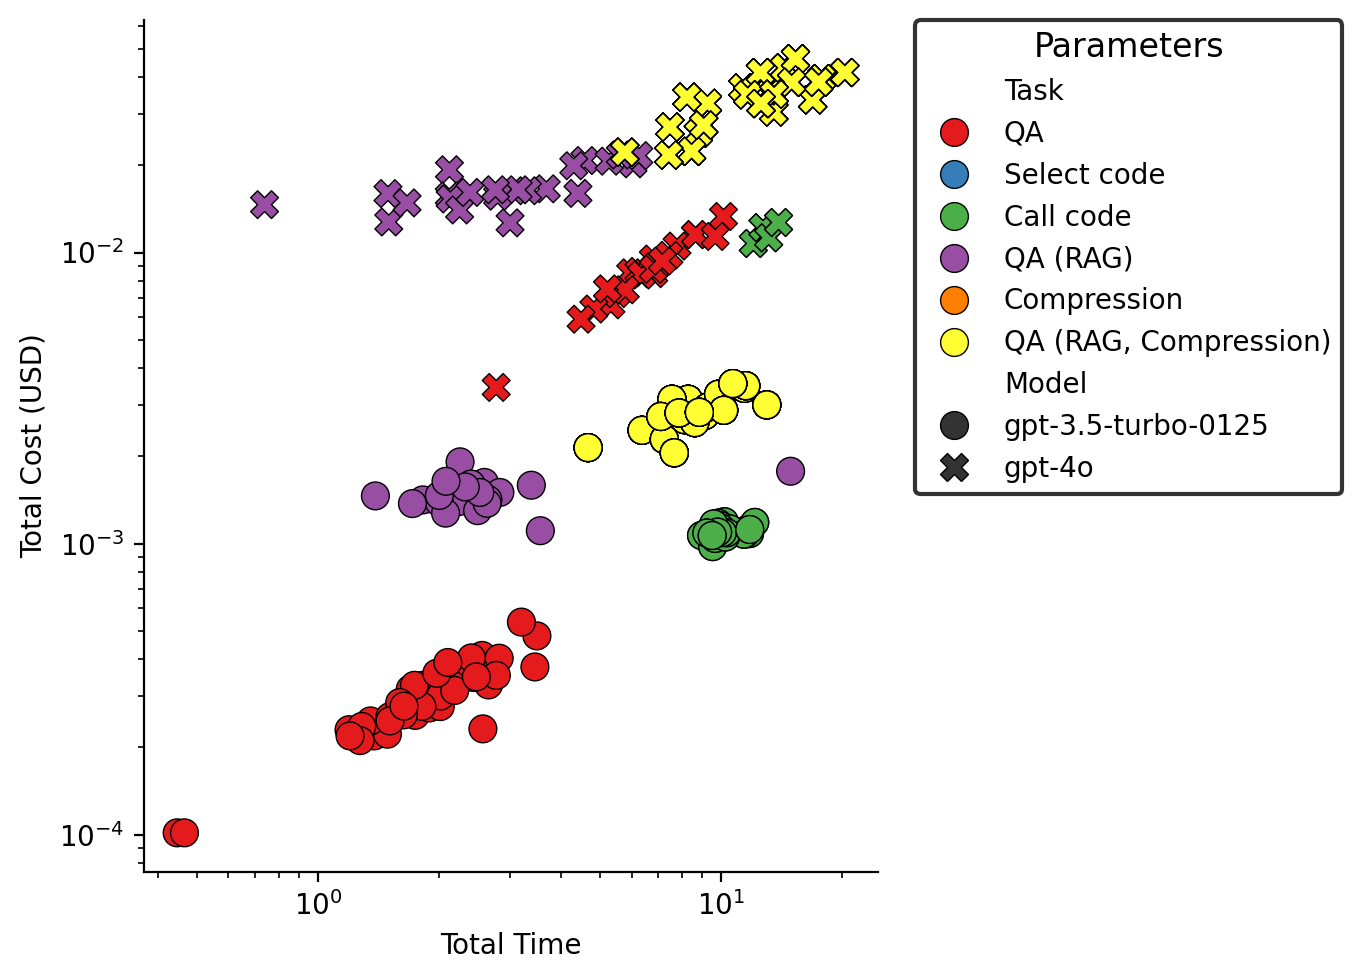

In [48]:
plt.figure(figsize=(7, 5), dpi=200)
scatter = sns.scatterplot(data=log_df,
                          x='Total Time',
                          y='Total Cost (USD)',
                          style='Model',
                          hue='Task',
                          s=100,           # Set the marker size
                          palette='Set1',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

plt.yscale('log')
plt.xscale('log')

legend = plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', 
                    borderaxespad=0, fontsize=10, title_fontsize=12, frameon=True)
frame = legend.get_frame()
frame.set_linewidth(1.5)  # Set the thickness of the border
frame.set_edgecolor('black')  # Set border color
# frame.set_boxstyle(FancyBboxPatch("square", pad=0.1))  # Square corners

sns.despine()
plt.tight_layout()
plt.show()


## Pairs Plots

<Figure size 2400x2100 with 0 Axes>

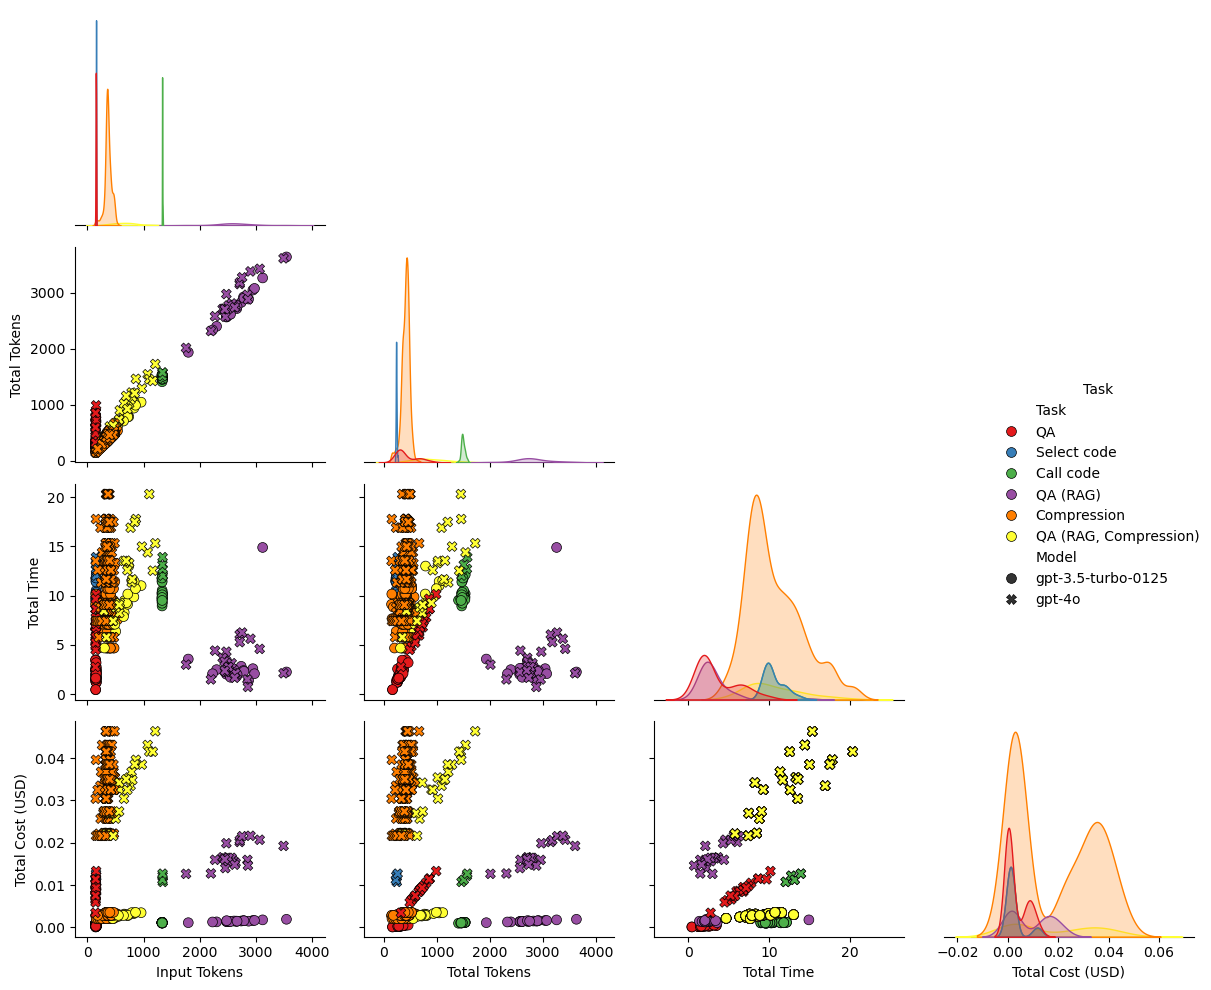

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables for the pairplot
plot_vars = ['Input Tokens', 'Total Tokens', 'Total Time', 'Total Cost (USD)',]

# Create the pairplot
plt.figure(figsize=(8, 7), dpi=300)
pairplot = sns.pairplot(data=log_df,
                        vars=plot_vars,
                        hue='Task',              # Color points by 'Task'
                        plot_kws={'s': 50,       # Marker size
                                  'edgecolor': 'black',  # Black edges around points
                                  'linewidth': 0.5,
                                  'style':log_df['Model']
                                 },     # Line width for edges
                        corner=True,             # Only plot lower triangle to avoid redundancy
                        height=2.5,              # Size of each subplot
                        palette='Set1')          # Use 'Set1' color palette for nice colors

# Improve layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


AttributeError: 'NoneType' object has no attribute 'get_xlabel'

<Figure size 2400x2100 with 0 Axes>

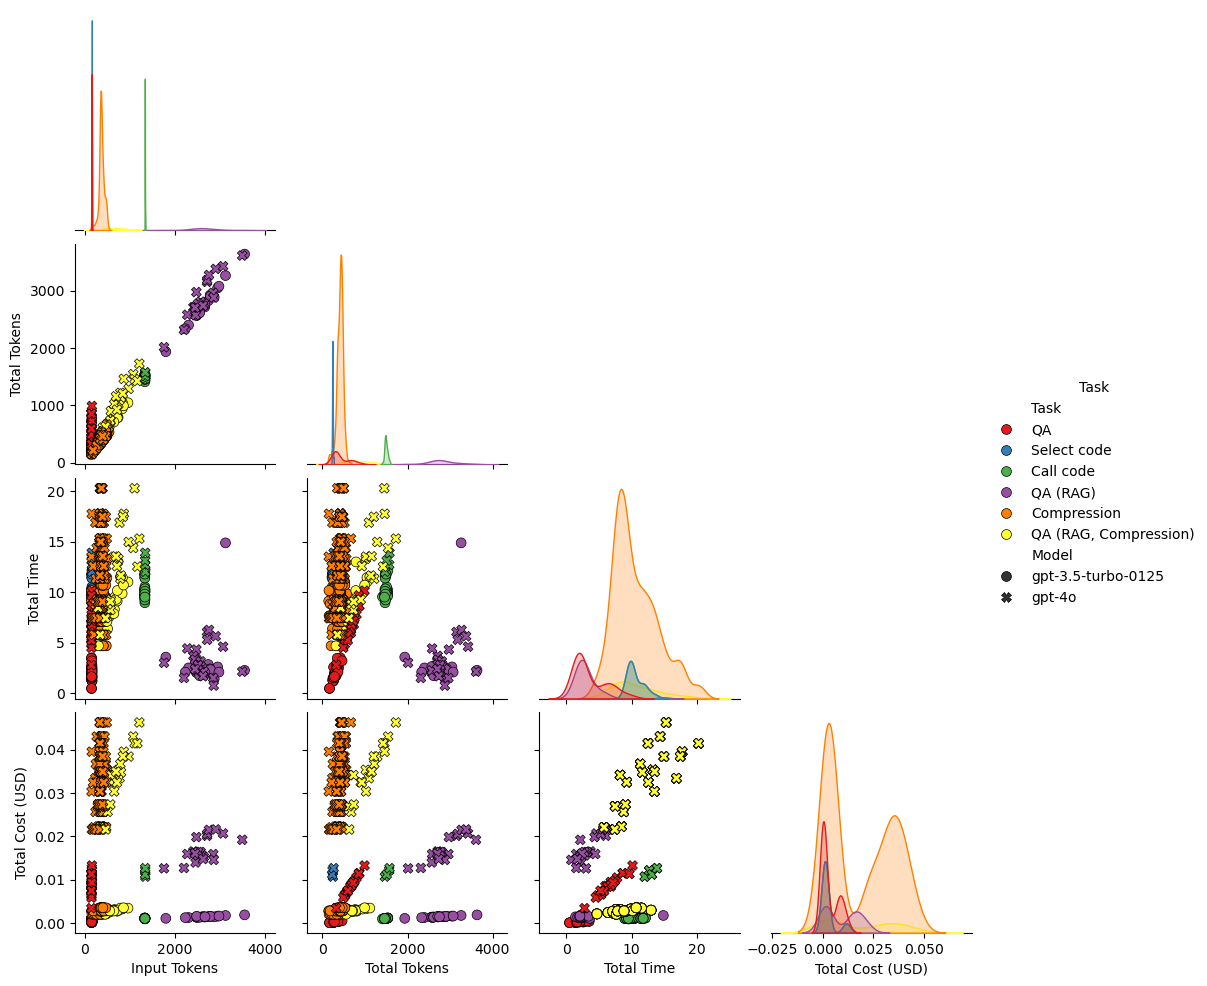

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables for the pairplot
plot_vars = ['Input Tokens', 'Total Tokens', 'Total Time', 'Total Cost (USD)',]

# Create the pairplot
plt.figure(figsize=(8, 7), dpi=300)
pairplot = sns.pairplot(data=log_df,
                        vars=plot_vars,
                        hue='Task',              # Color points by 'Task'
                        plot_kws={'s': 50,       # Marker size
                                  'edgecolor': 'black',  # Black edges around points
                                  'linewidth': 0.5,
                                  'style':log_df['Model']
                                 },     # Line width for edges
                        corner=True,             # Only plot lower triangle to avoid redundancy
                        height=2.5,              # Size of each subplot
                        palette='Set1')          # Use 'Set1' color palette for nice colors

for ax in pairplot.axes.flat:
    if ax.get_xlabel() in ['Input Tokens']:
        ax.set(xscale="log")


In [76]:
pairplot.axes[1].xlabel

AttributeError: 'numpy.ndarray' object has no attribute 'xlabel'

<Figure size 2400x2400 with 0 Axes>

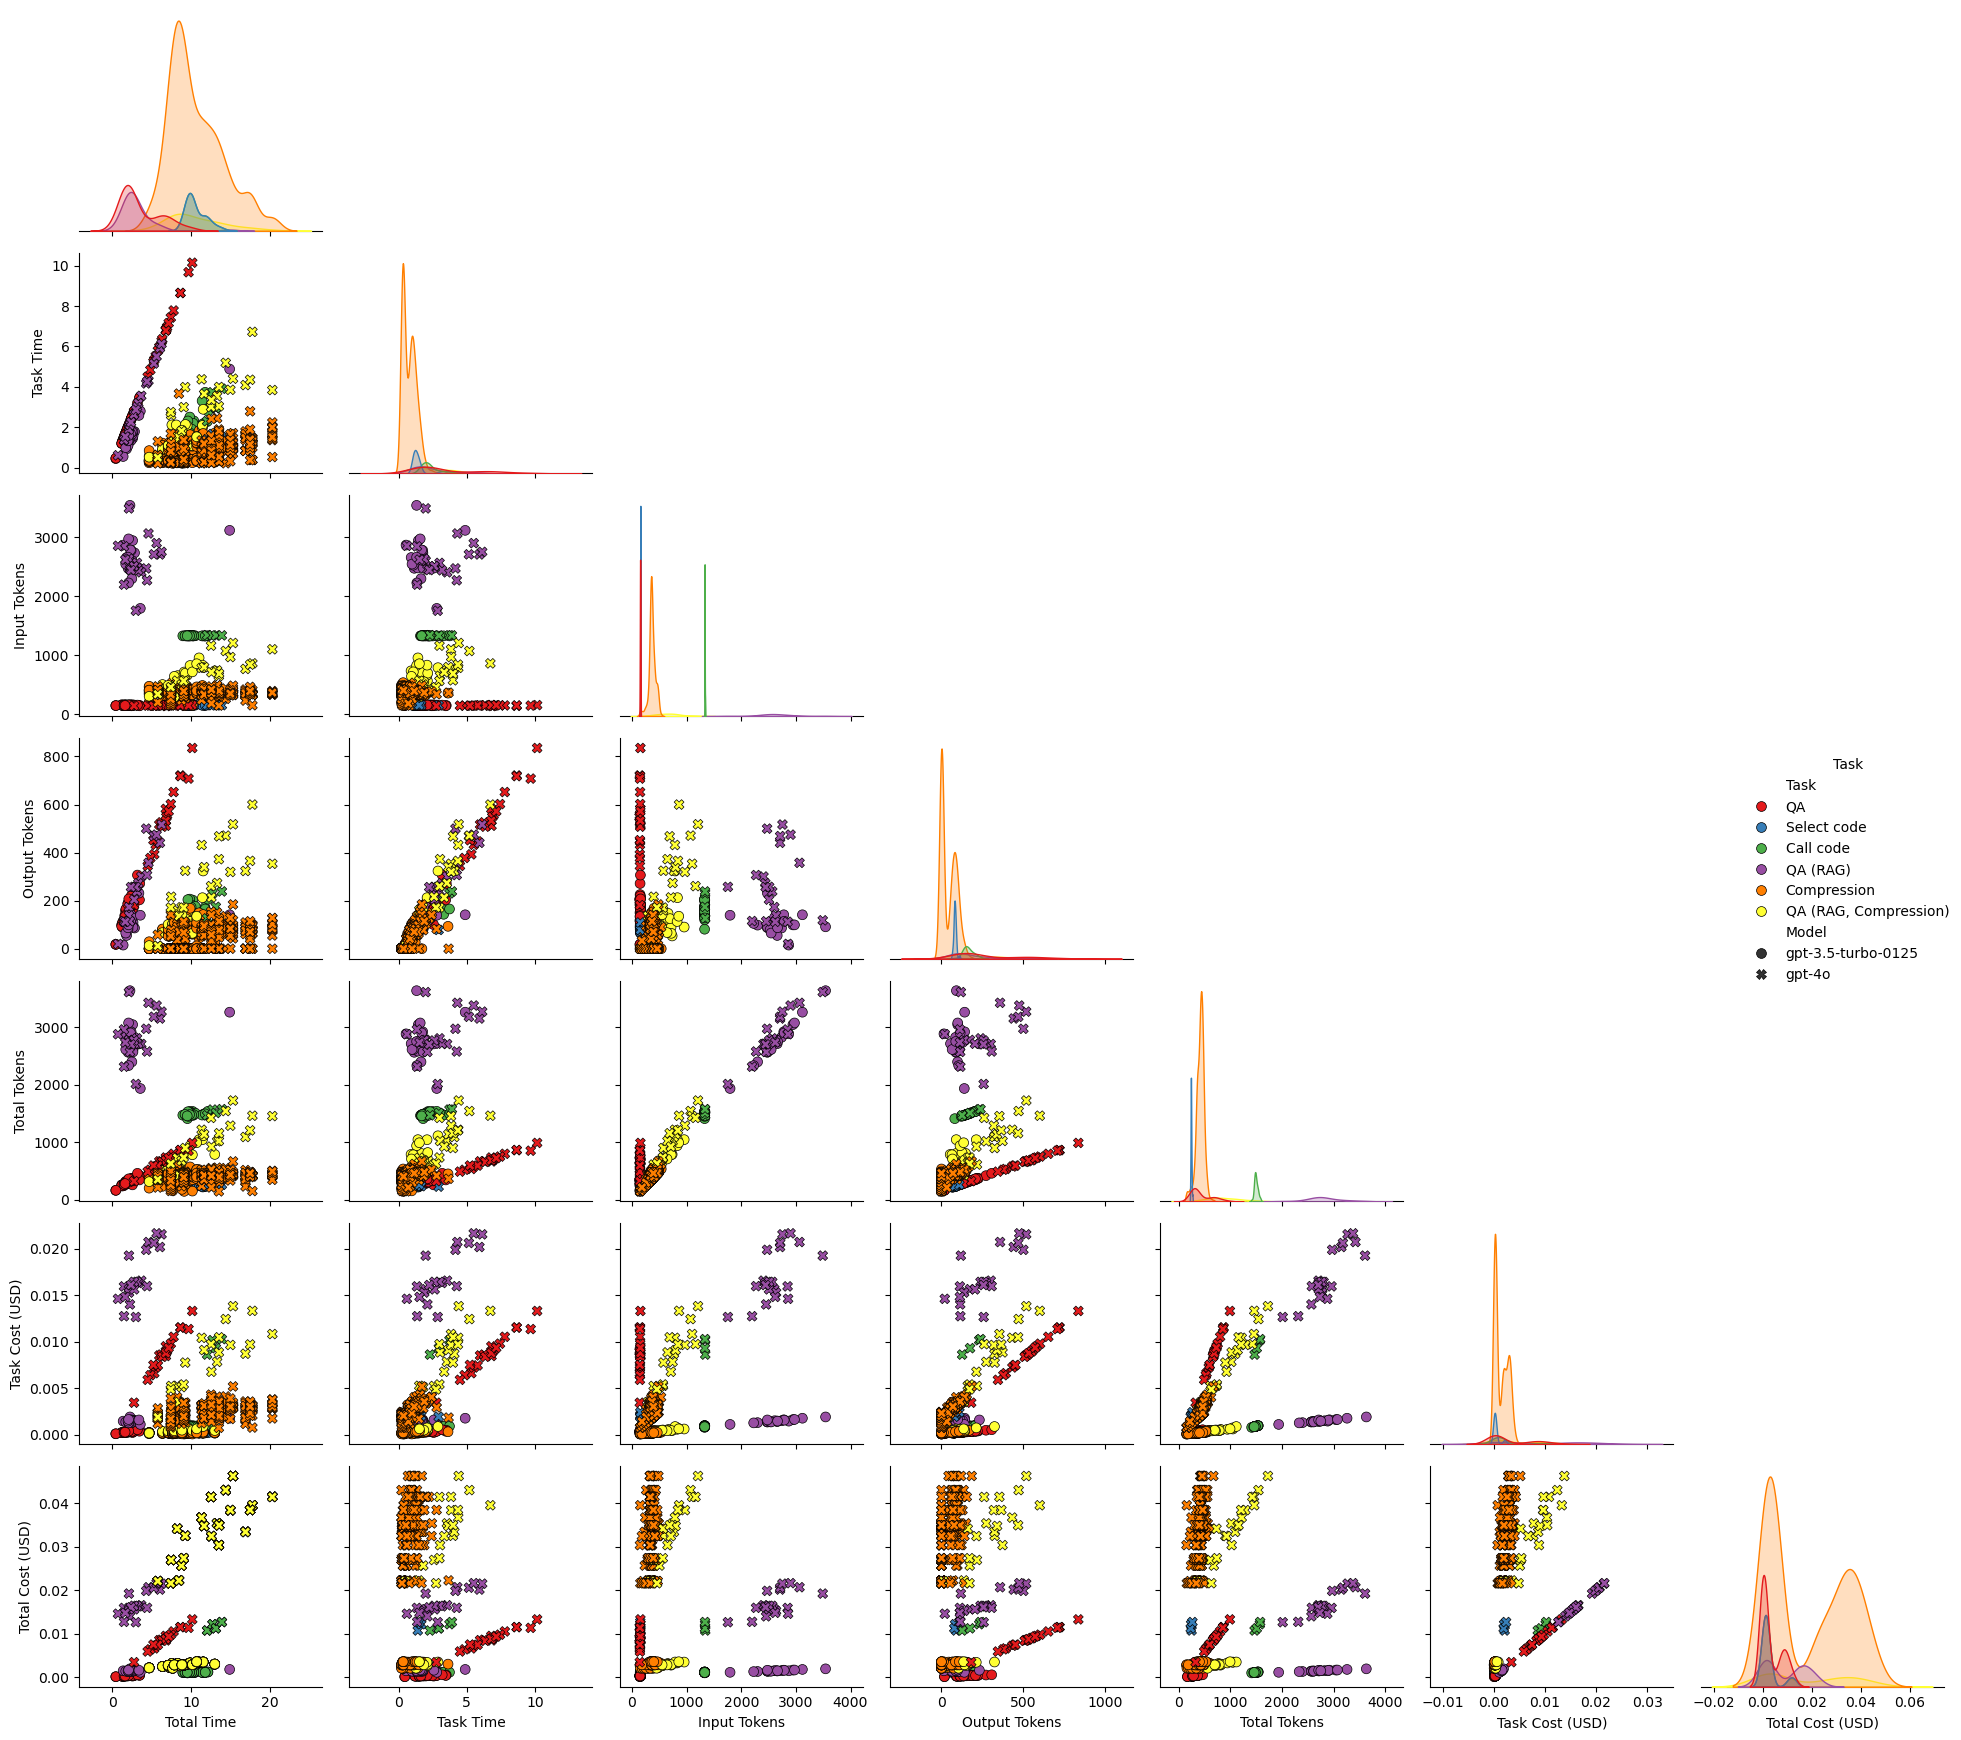

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8), dpi=300)
pairplot = sns.pairplot(data=log_df, 
                        hue='Task',              # Color points by 'Task'
                        plot_kws={'s': 50,       # Marker size
                                  'edgecolor': 'black',  # Black edges around points
                                  'linewidth': 0.5,
                                  'style': log_df['Model']
                                 },     # Line width for edges
                        corner=True,             # Only plot lower triangle to avoid redundancy
                        height=2.5,              # Size of each subplot
                        palette='Set1')       # Use the 'viridis' color palette for nice colors

# Improve layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


## Token Costs

/home/jpic/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/home/jpic/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/home/jpic/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/home/jpic/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/home/jpic/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: 
The m

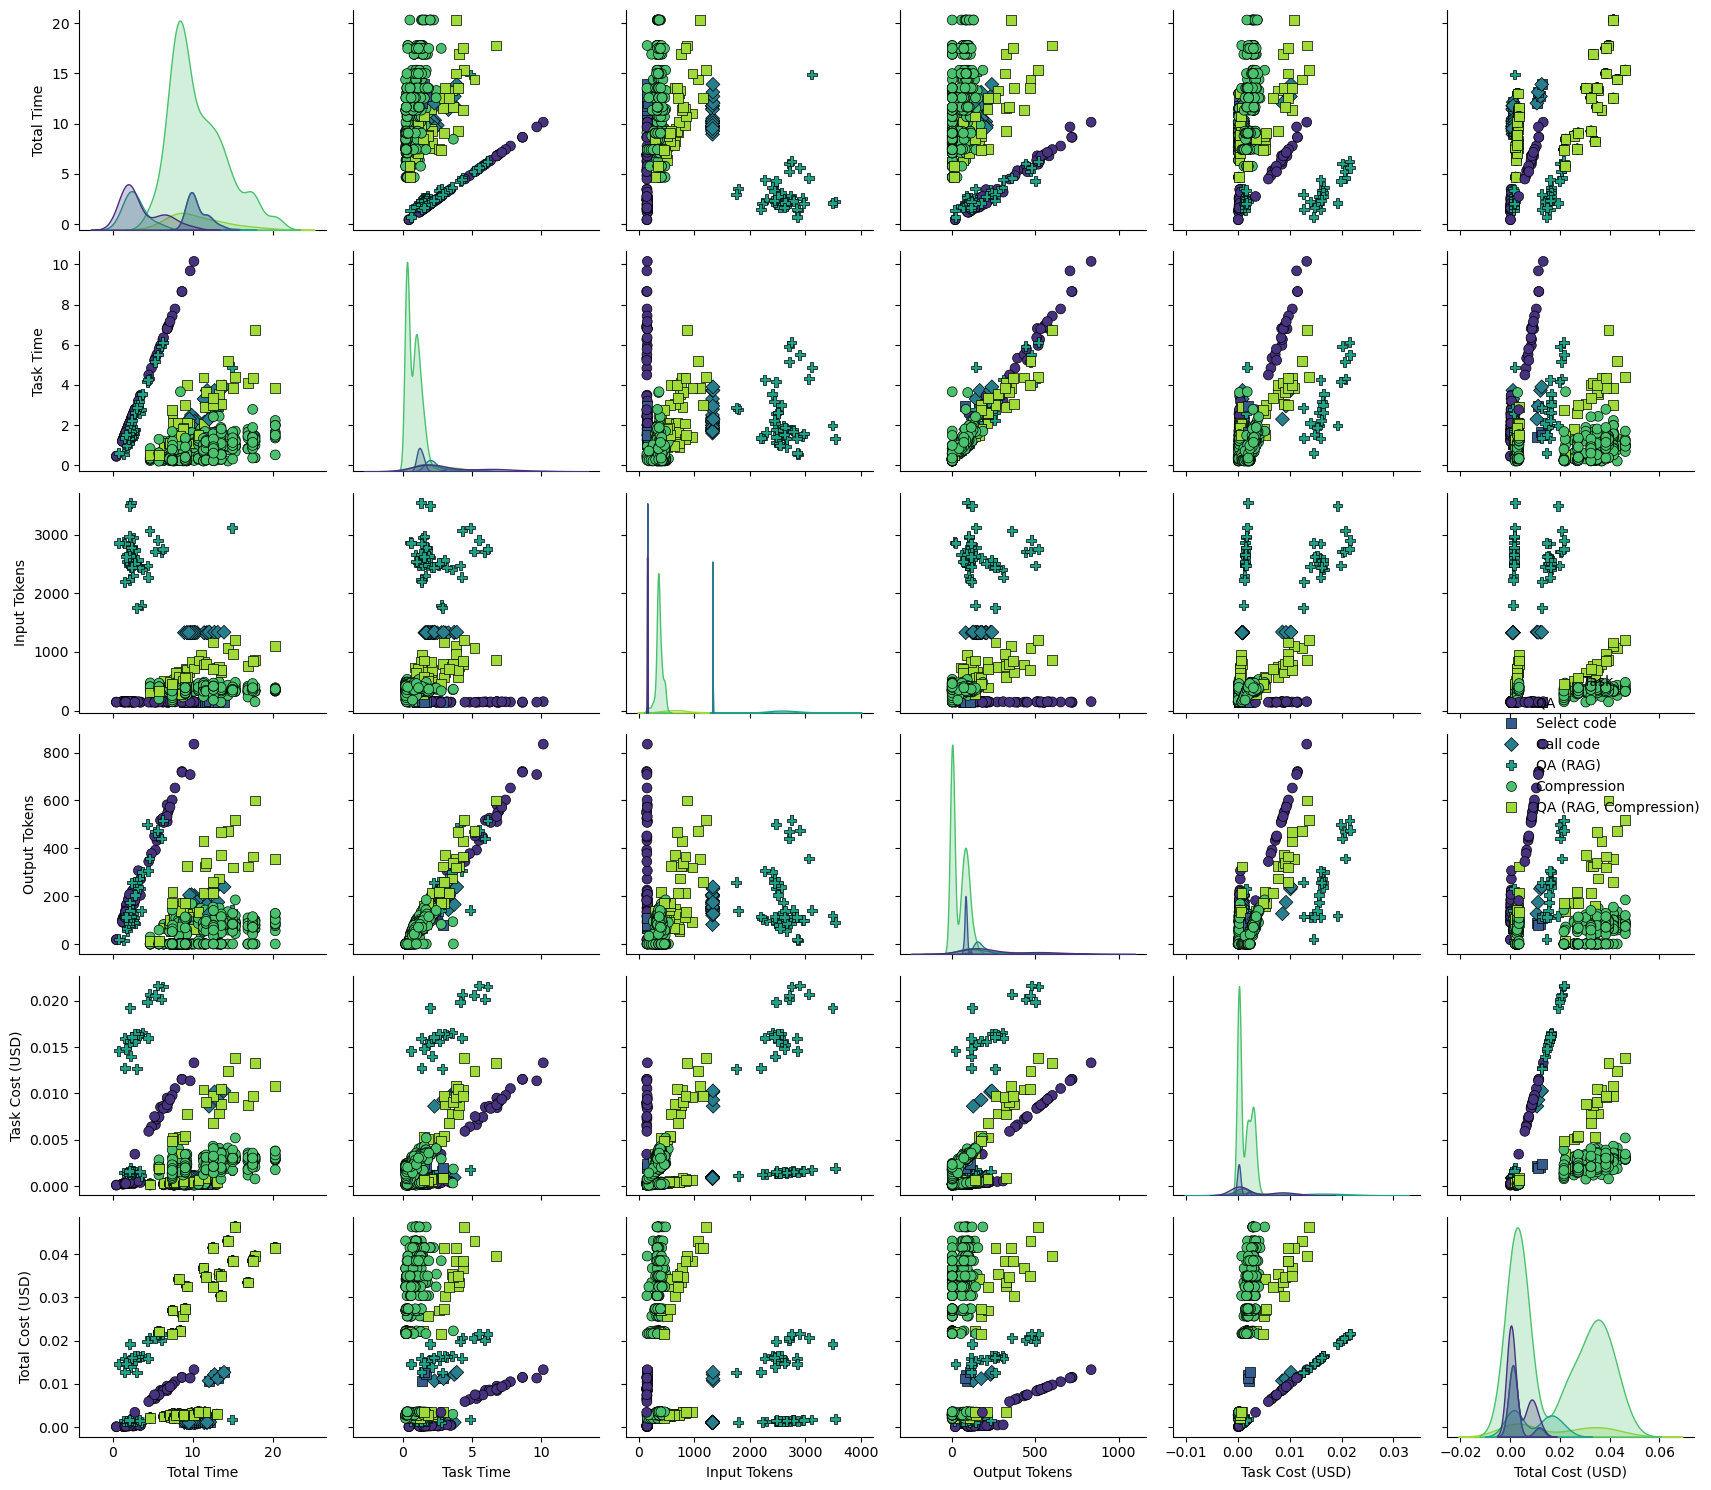

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pairplot
sns.pairplot(data=log_df,
             hue='Task',           # Use 'Task' to color the markers
             markers=["o", "s", "D", "P"],  # Define marker styles manually if needed
             plot_kws={'s': 50,    # Marker size
                       'edgecolor': 'black',  # Black edge on markers
                       'linewidth': 0.5},     # Line width for marker edges
             height=2.5,           # Set size of the individual plots
             palette='viridis')     # Use the viridis color palette for better distinction

# Adjust layout for better readability
plt.tight_layout()

# Display the plot
plt.show()


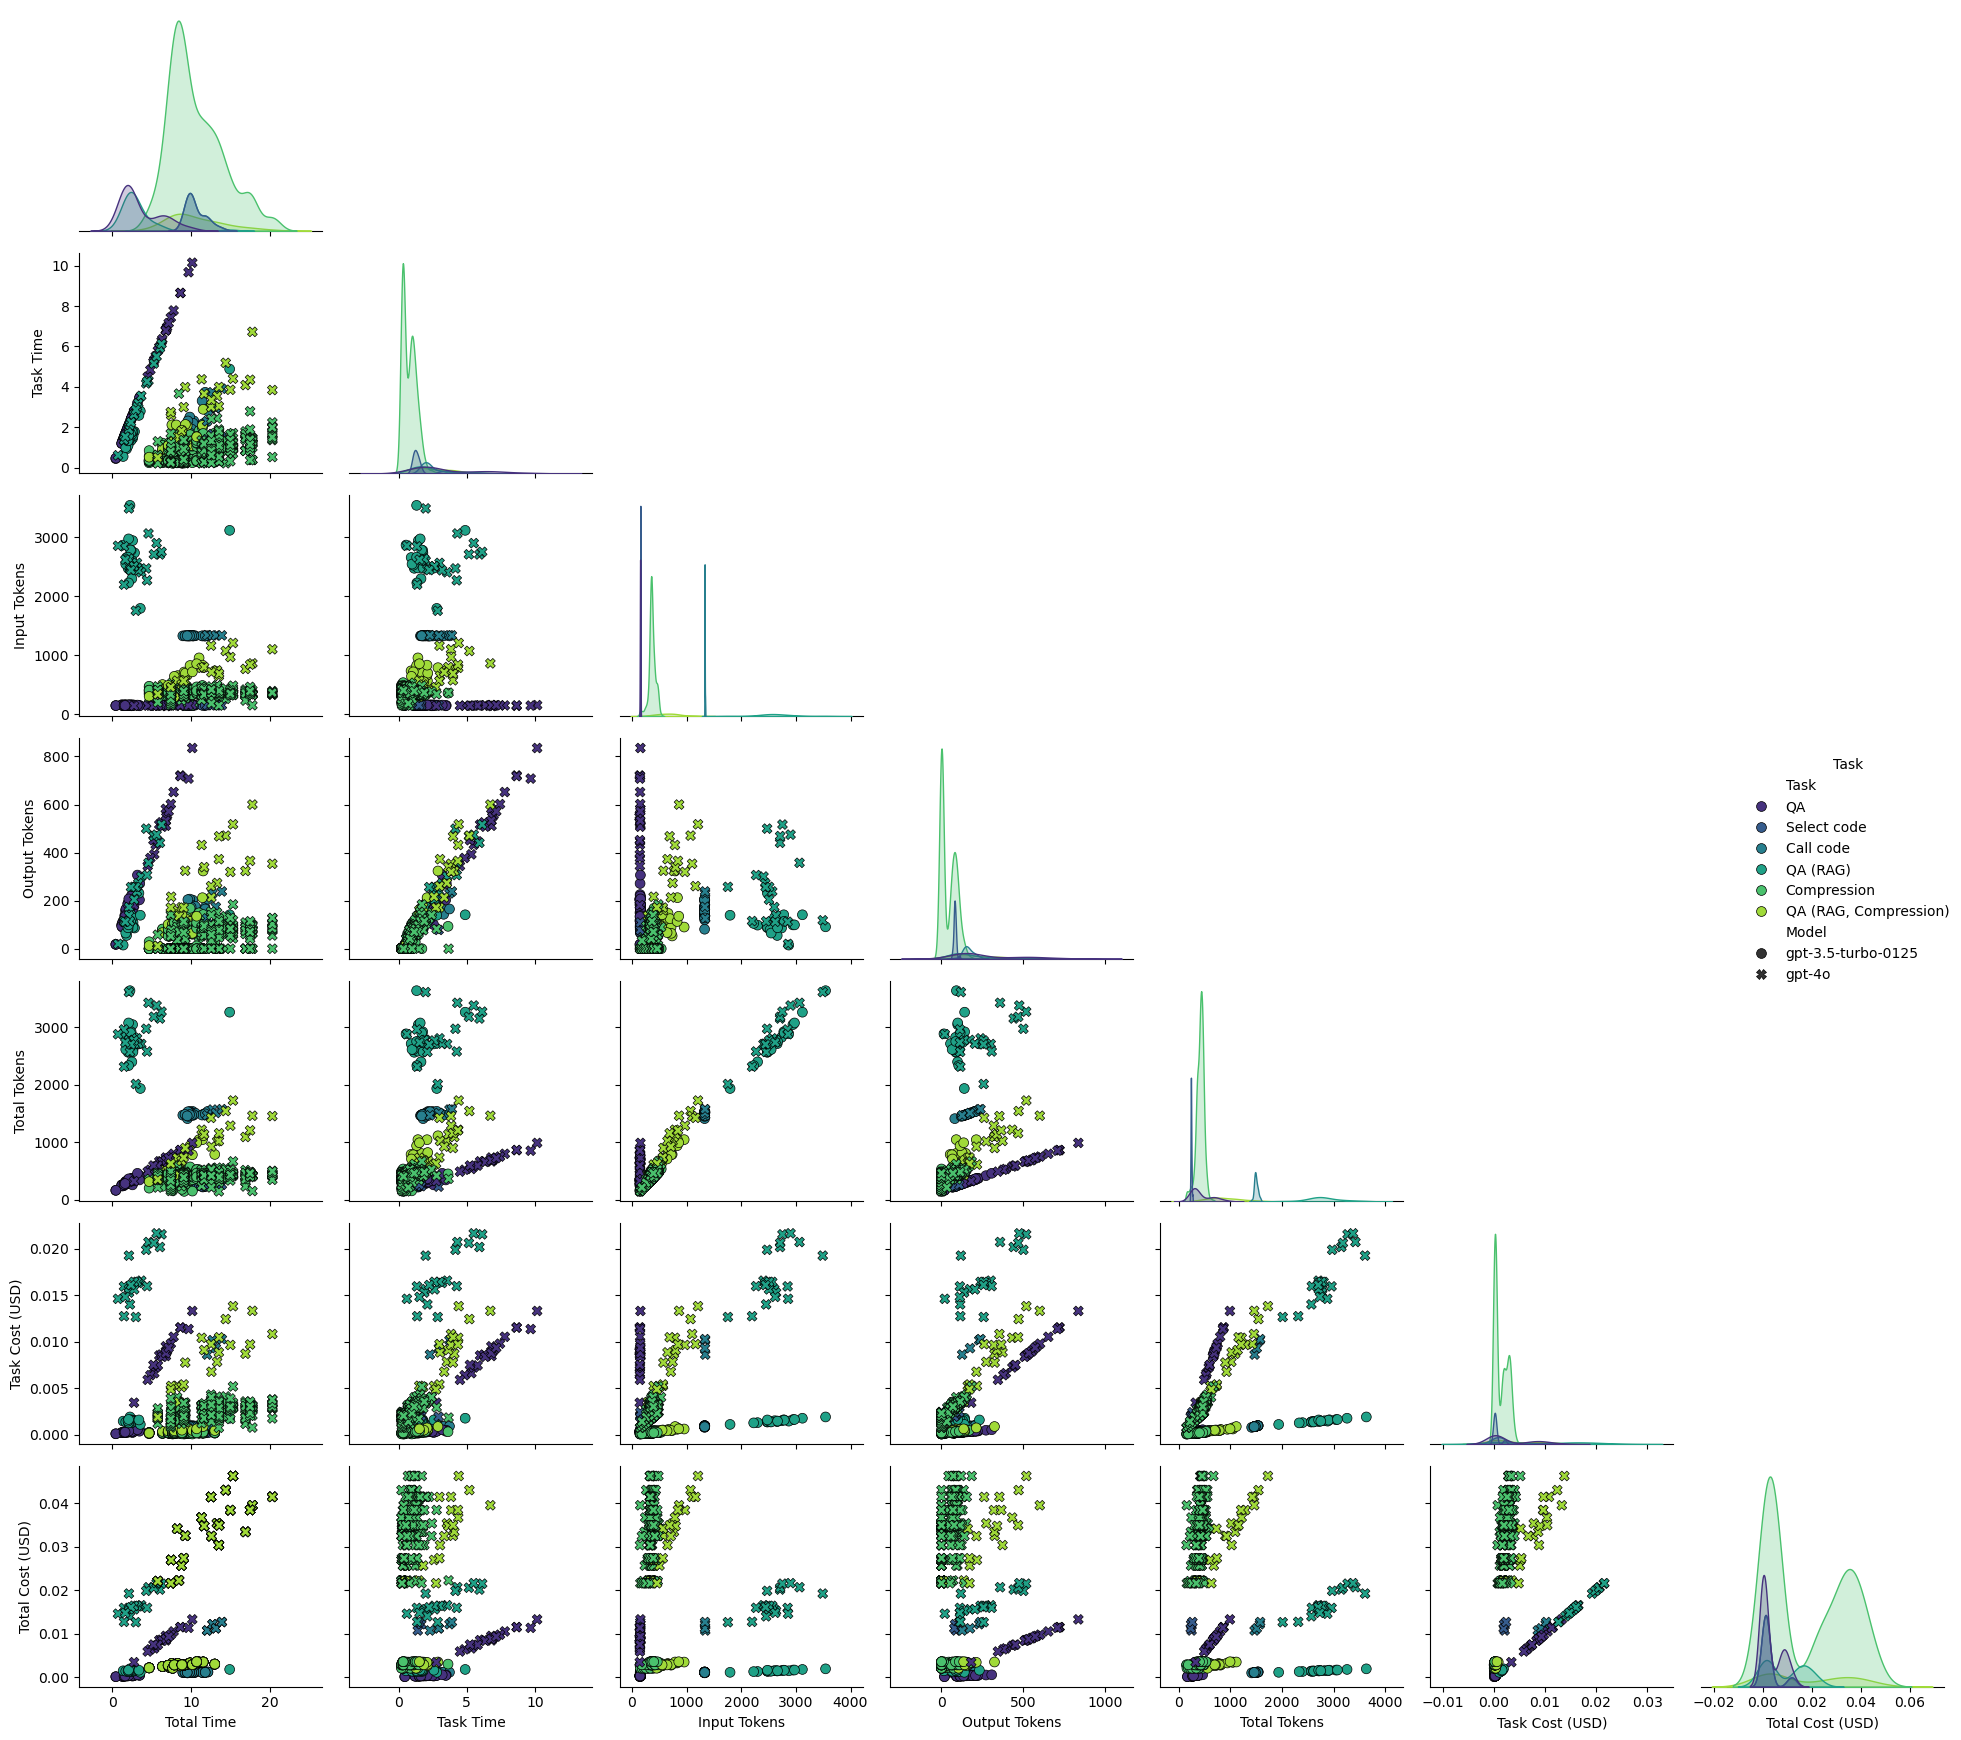

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the pairplot with 'hue' for color differentiation
pairplot = sns.pairplot(data=log_df, 
                        hue='Task',              # Color points by 'Task'
                        plot_kws={'s': 50,       # Marker size
                                  'edgecolor': 'black',  # Black edges around points
                                  'linewidth': 0.5,
                                  'style': log_df['Model']
                                 },     # Line width for edges
                        corner=True,             # Only plot lower triangle to avoid redundancy
                        height=2.5,              # Size of each subplot
                        palette='viridis')       # Use the 'viridis' color palette for nice colors

# Improve layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


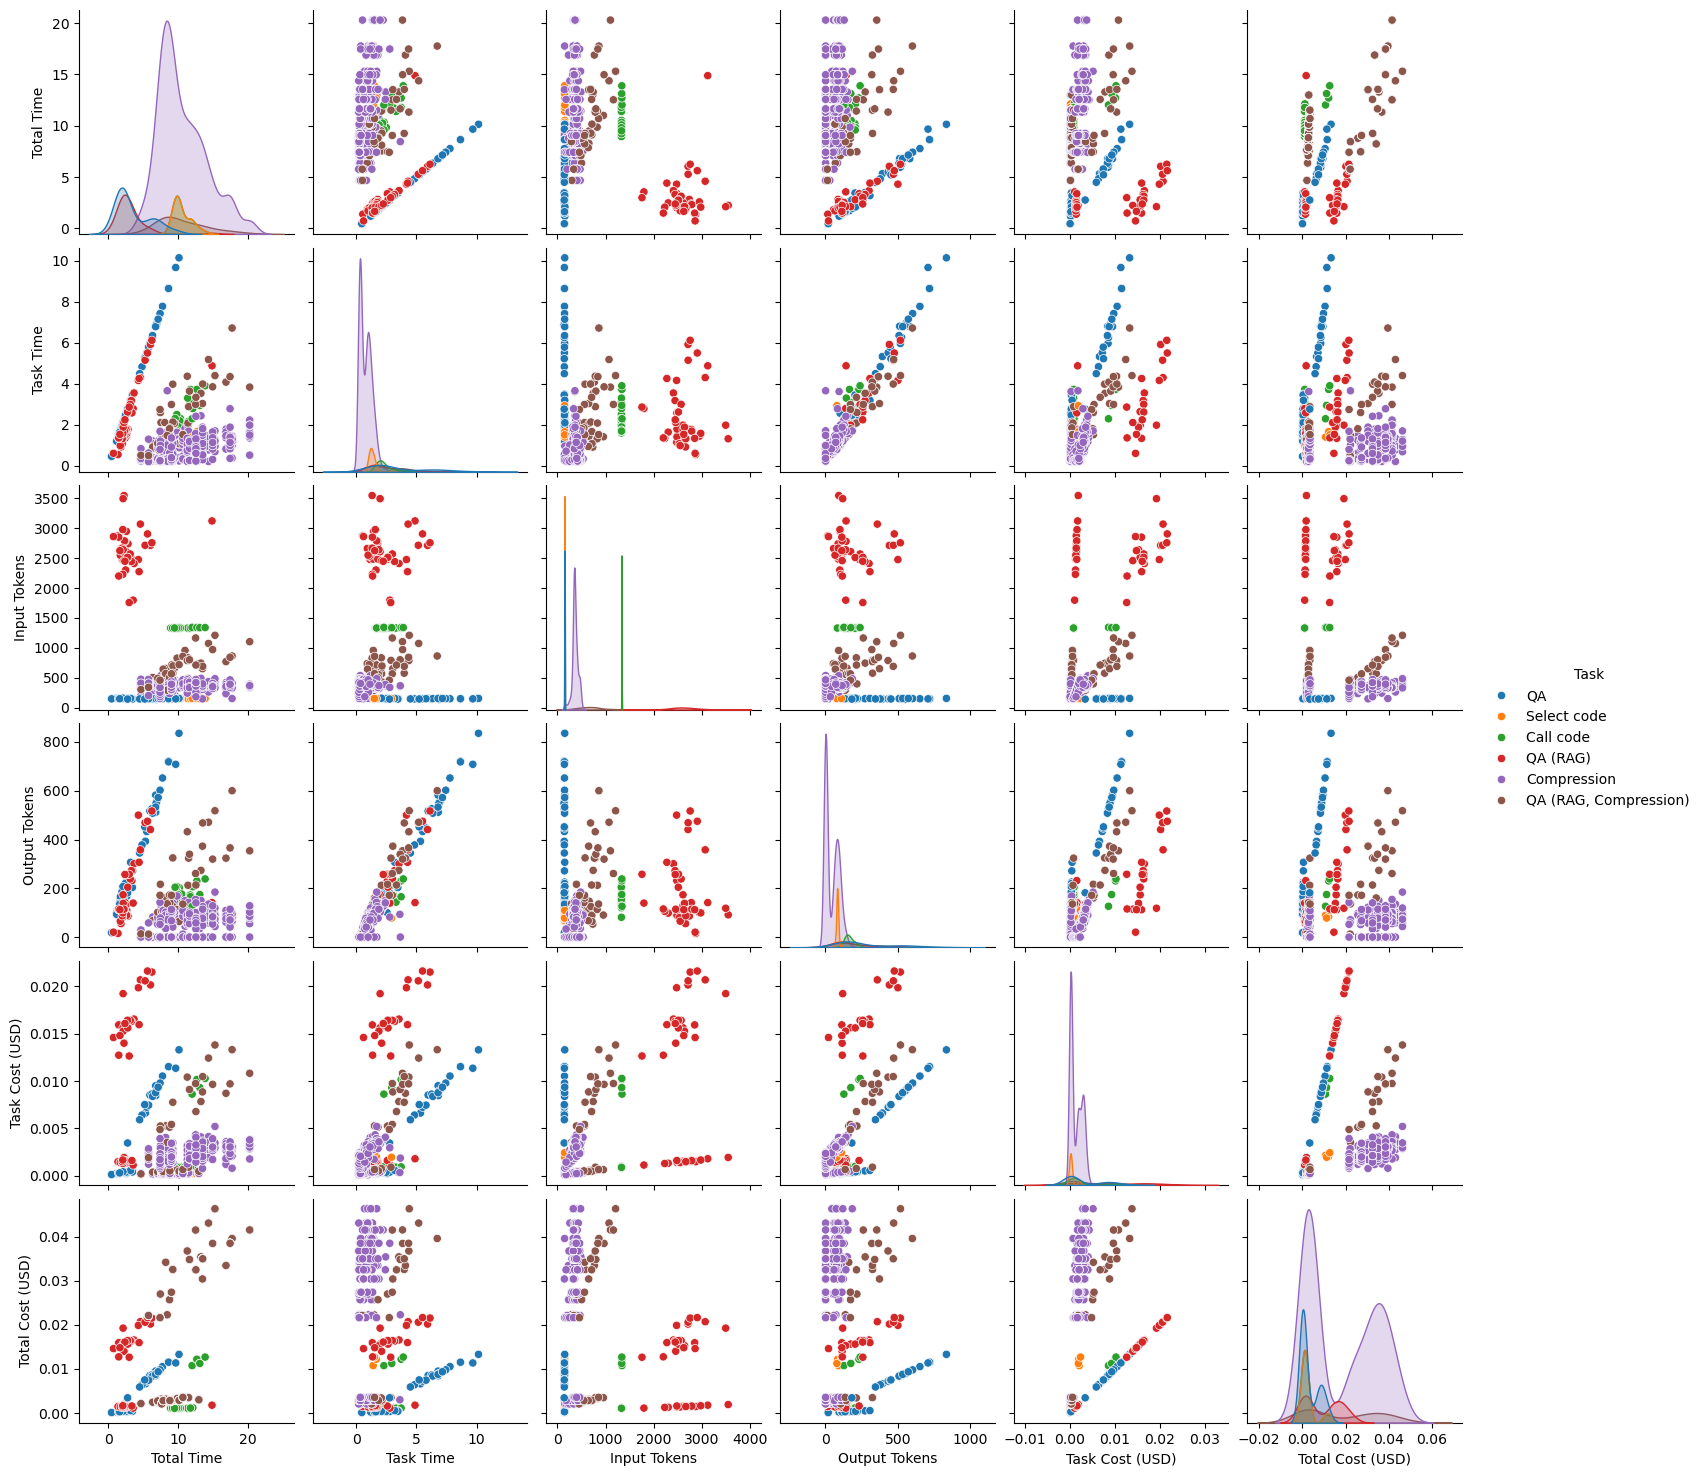

In [36]:
sns.pairplot(data=log_df,
             hue='Task'
            )

## Run Times

# Scratch

<Axes: xlabel='Total Time', ylabel='Count'>

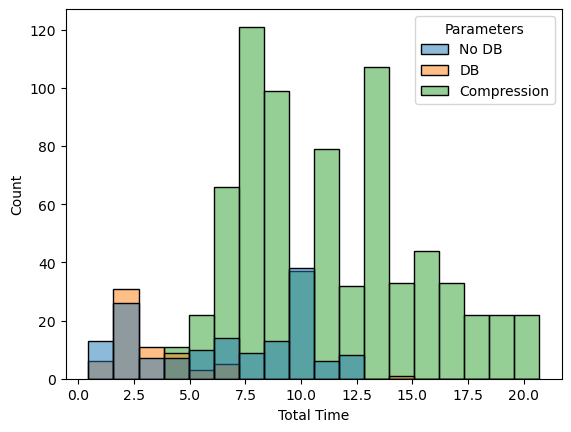

In [223]:
sns.histplot(data=log_df,
             x='Total Time',
             hue='Parameters')

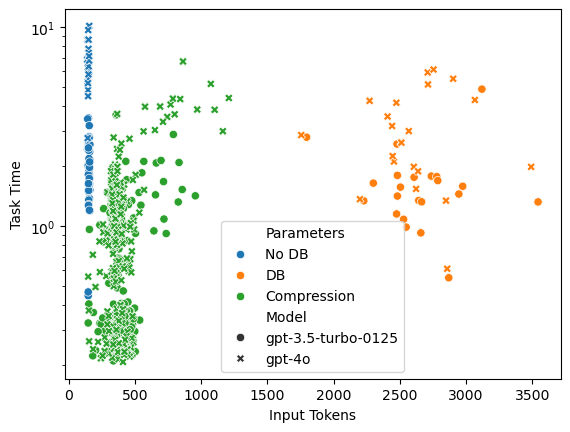

In [123]:
sns.scatterplot(data=log_df,
             x='Input Tokens',
             y='Task Time',
             style='Model',
             hue='Parameters')
plt.yscale('log')

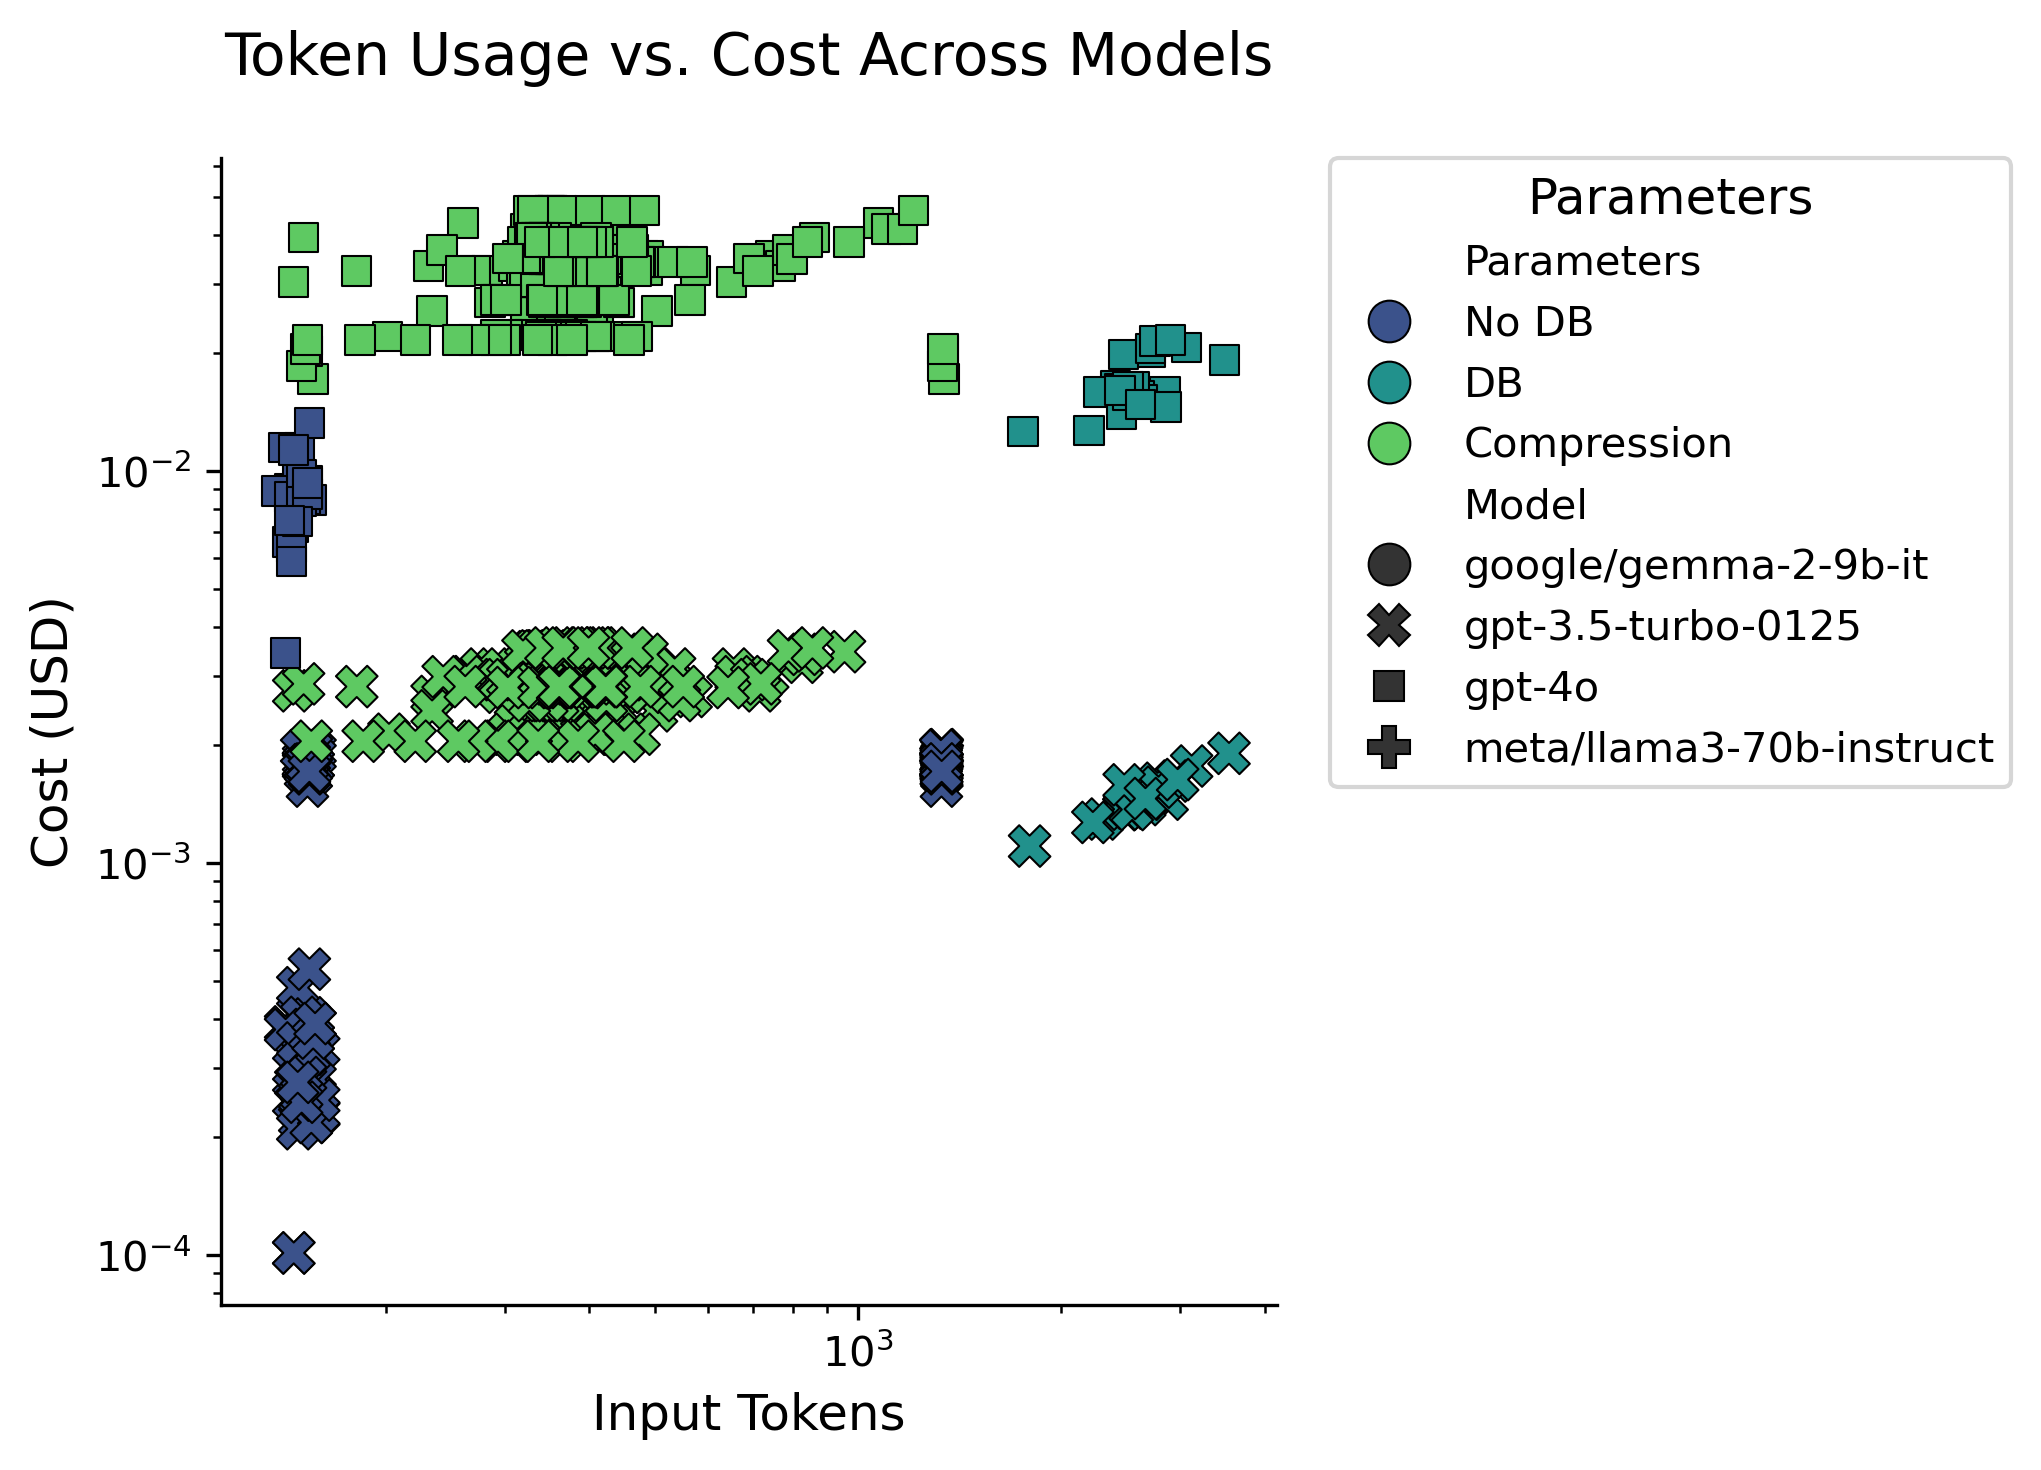

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and DPI for high resolution
plt.figure(figsize=(7, 5), dpi=300)

# Create the scatter plot
scatter = sns.scatterplot(data=log_df,
                          x='Input Tokens',
                          y='Total Cost (USD)',
                          style='Model',
                          hue='Parameters',
                          s=100,           # Set the marker size
                          palette='viridis',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

# Use logarithmic scale for both axes
plt.yscale('log')
plt.xscale('log')

# Customize axis labels
plt.xlabel('Input Tokens', fontsize=12)
plt.ylabel('Cost (USD)', fontsize=12)

# Add a title (optional) and remove if not needed
plt.title('Token Usage vs. Cost Across Models', fontsize=14, pad=20)

# Adjust legend settings for better readability
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10, title_fontsize=12)

# Despine for a cleaner look
sns.despine()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


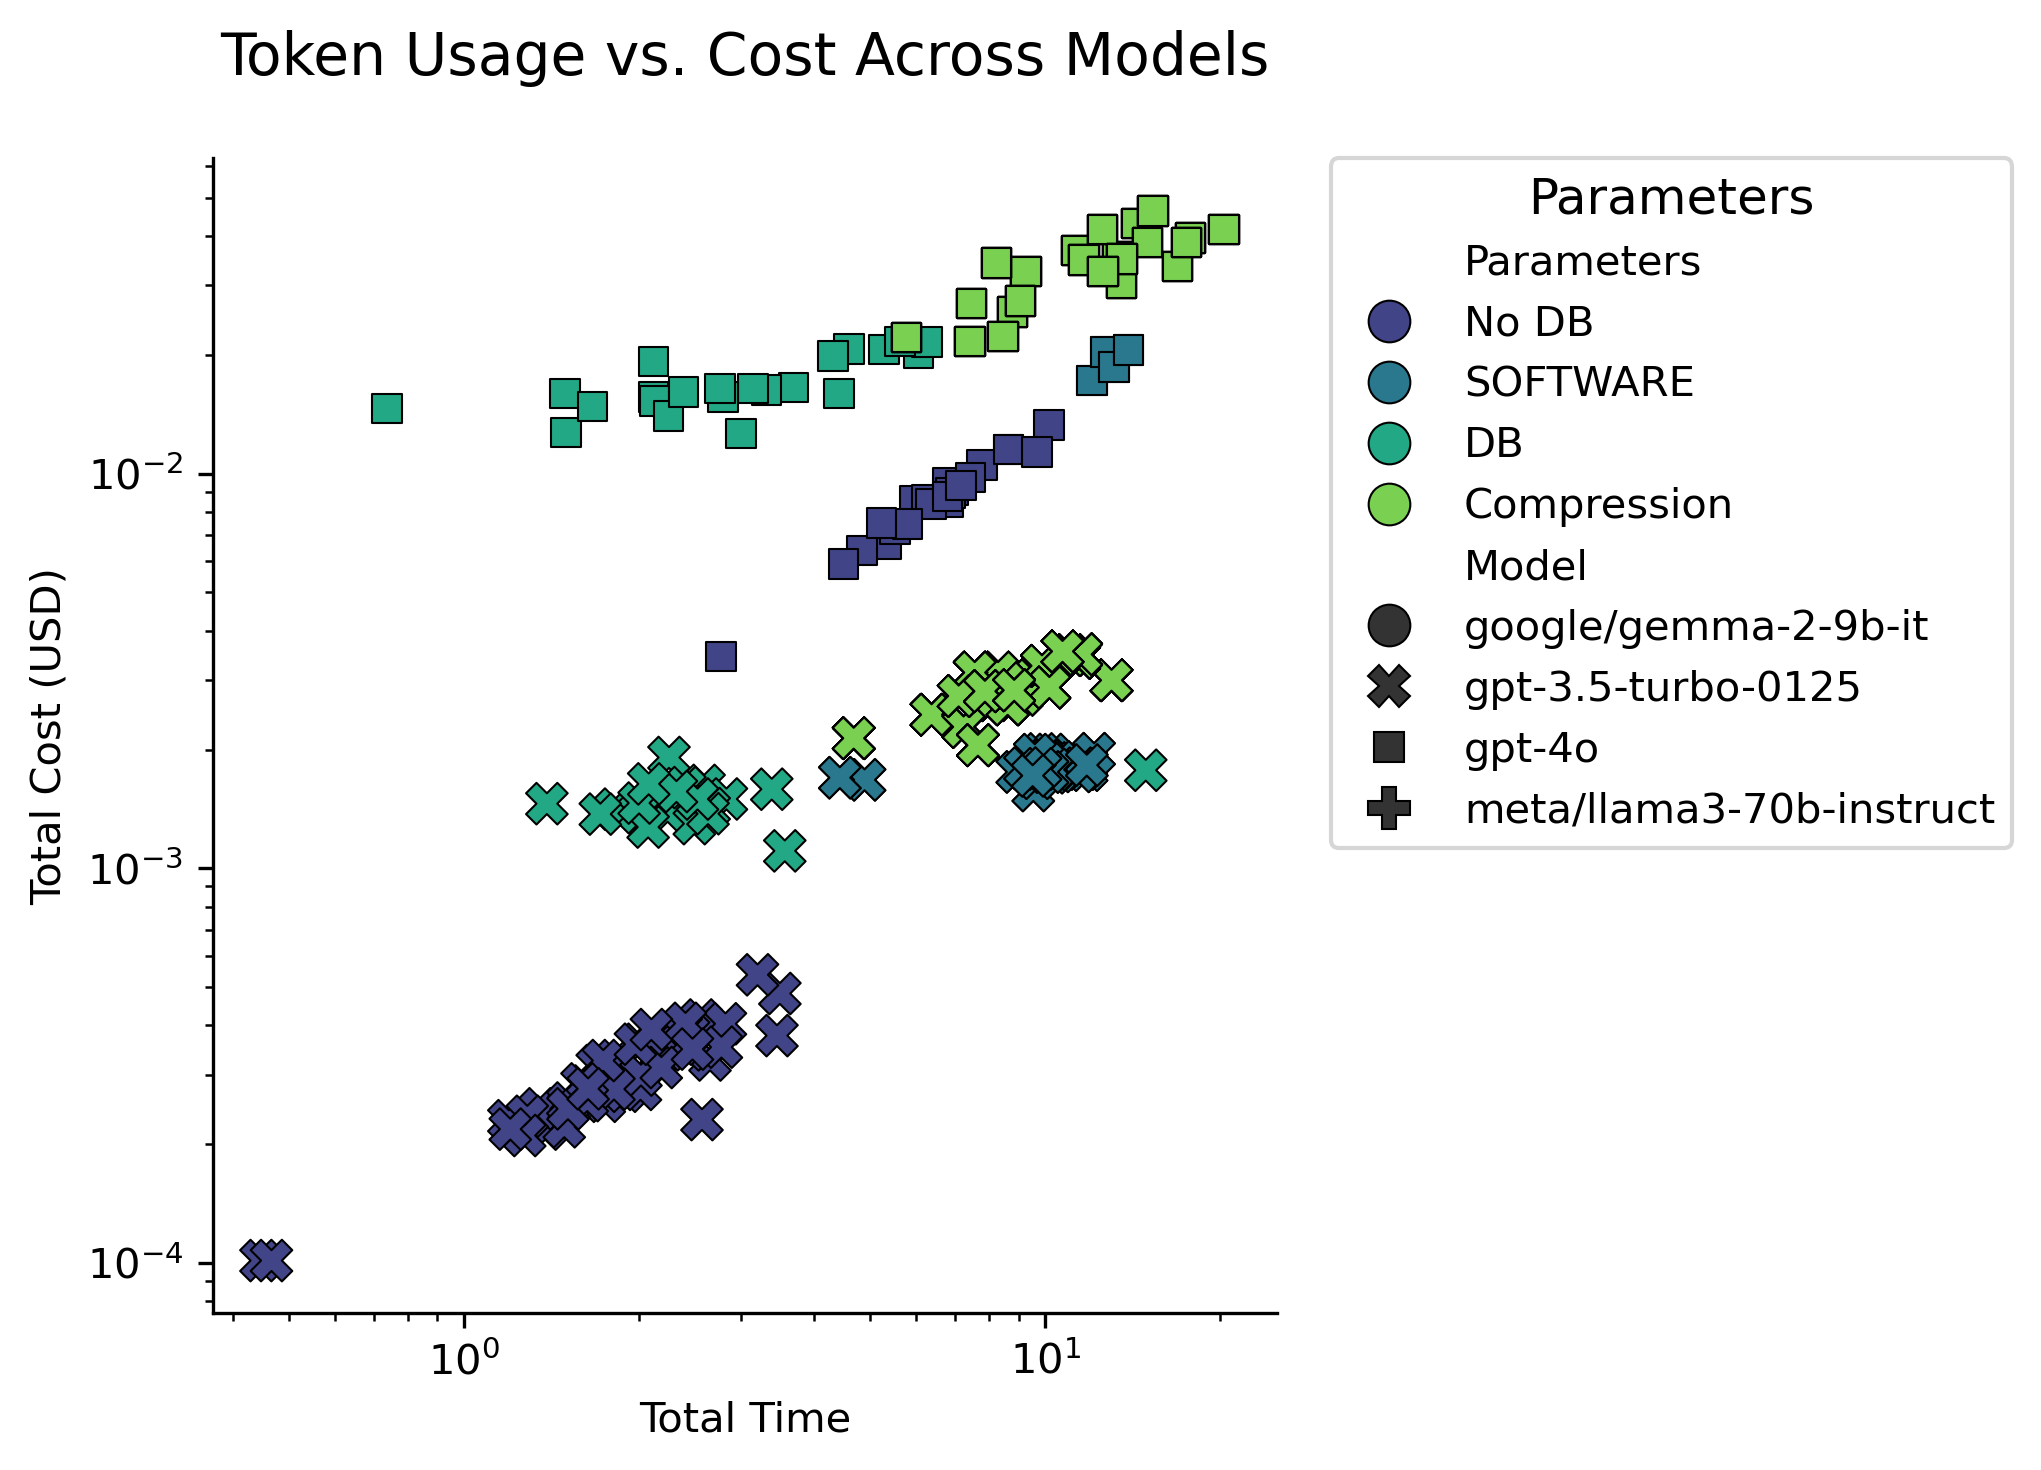

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and DPI for high resolution
plt.figure(figsize=(7, 5), dpi=300)

# Create the scatter plot
scatter = sns.scatterplot(data=log_df,
                          x='Total Time',
                          y='Total Cost (USD)',
                          style='Model',
                          hue='Parameters',
                          s=100,           # Set the marker size
                          palette='viridis',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

# Use logarithmic scale for both axes
plt.yscale('log')
plt.xscale('log')

# Add a title (optional) and remove if not needed
plt.title('Token Usage vs. Cost Across Models', fontsize=14, pad=20)

# Adjust legend settings for better readability
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10, title_fontsize=12)

# Despine for a cleaner look
sns.despine()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


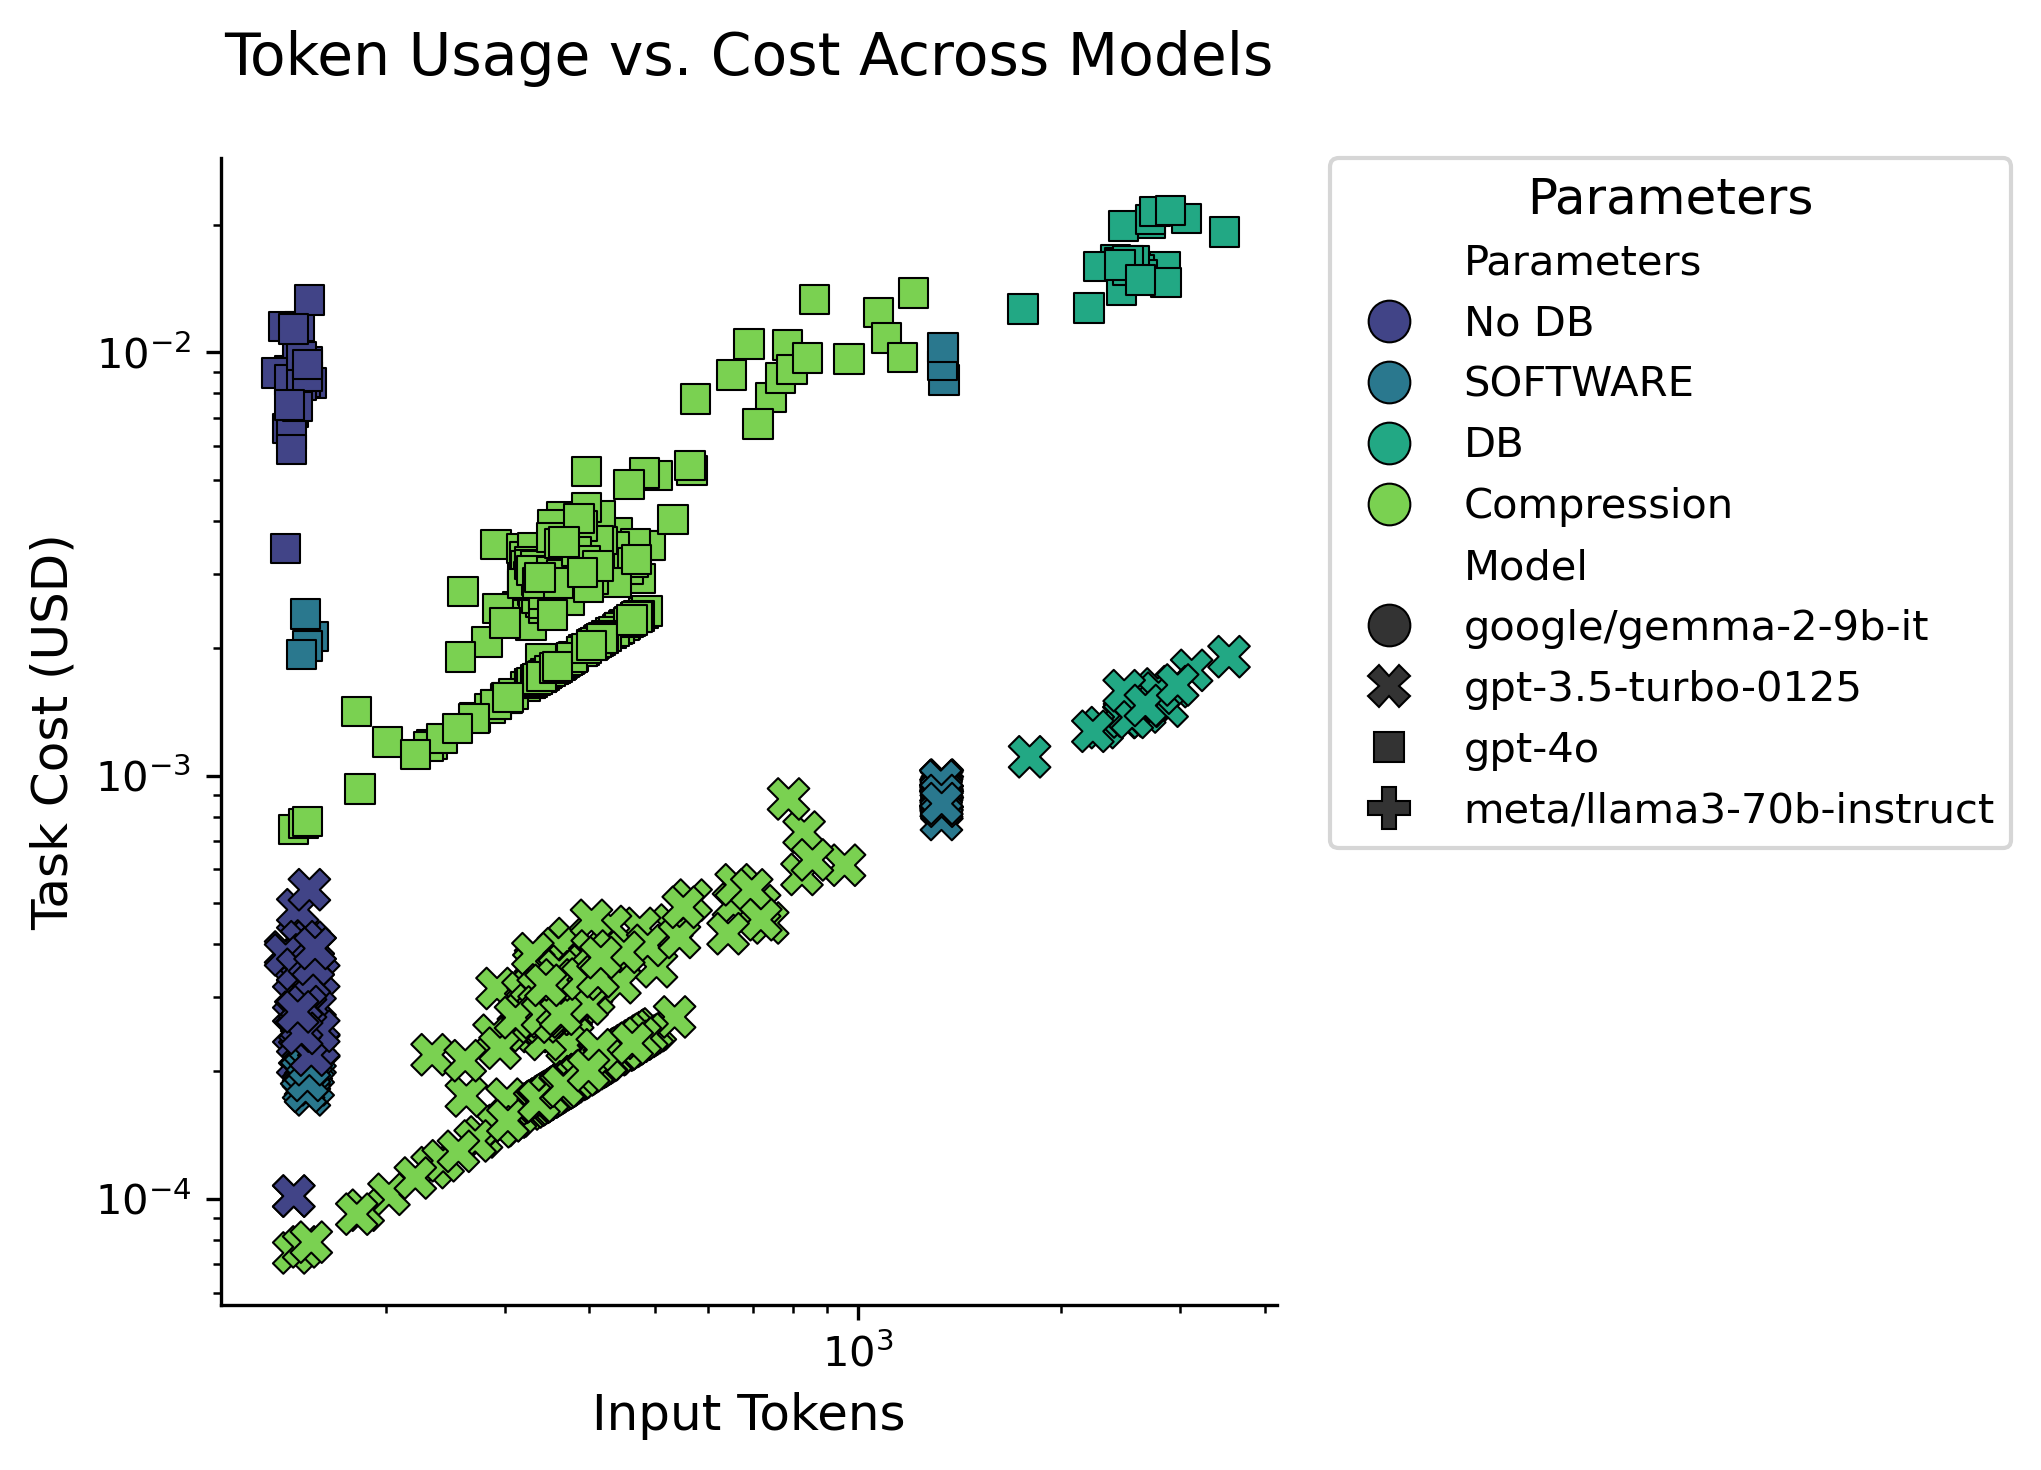

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and DPI for high resolution
plt.figure(figsize=(7, 5), dpi=300)

# Create the scatter plot
scatter = sns.scatterplot(data=log_df,
                          x='Input Tokens',
                          y='Task Cost (USD)',
                          style='Model',
                          hue='Parameters',
                          s=100,           # Set the marker size
                          palette='viridis',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

# Use logarithmic scale for both axes
plt.yscale('log')
plt.xscale('log')

# Customize axis labels
plt.xlabel('Input Tokens', fontsize=12)
plt.ylabel('Task Cost (USD)', fontsize=12)

# Add a title (optional) and remove if not needed
plt.title('Token Usage vs. Cost Across Models', fontsize=14, pad=20)

# Adjust legend settings for better readability
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10, title_fontsize=12)

# Despine for a cleaner look
sns.despine()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


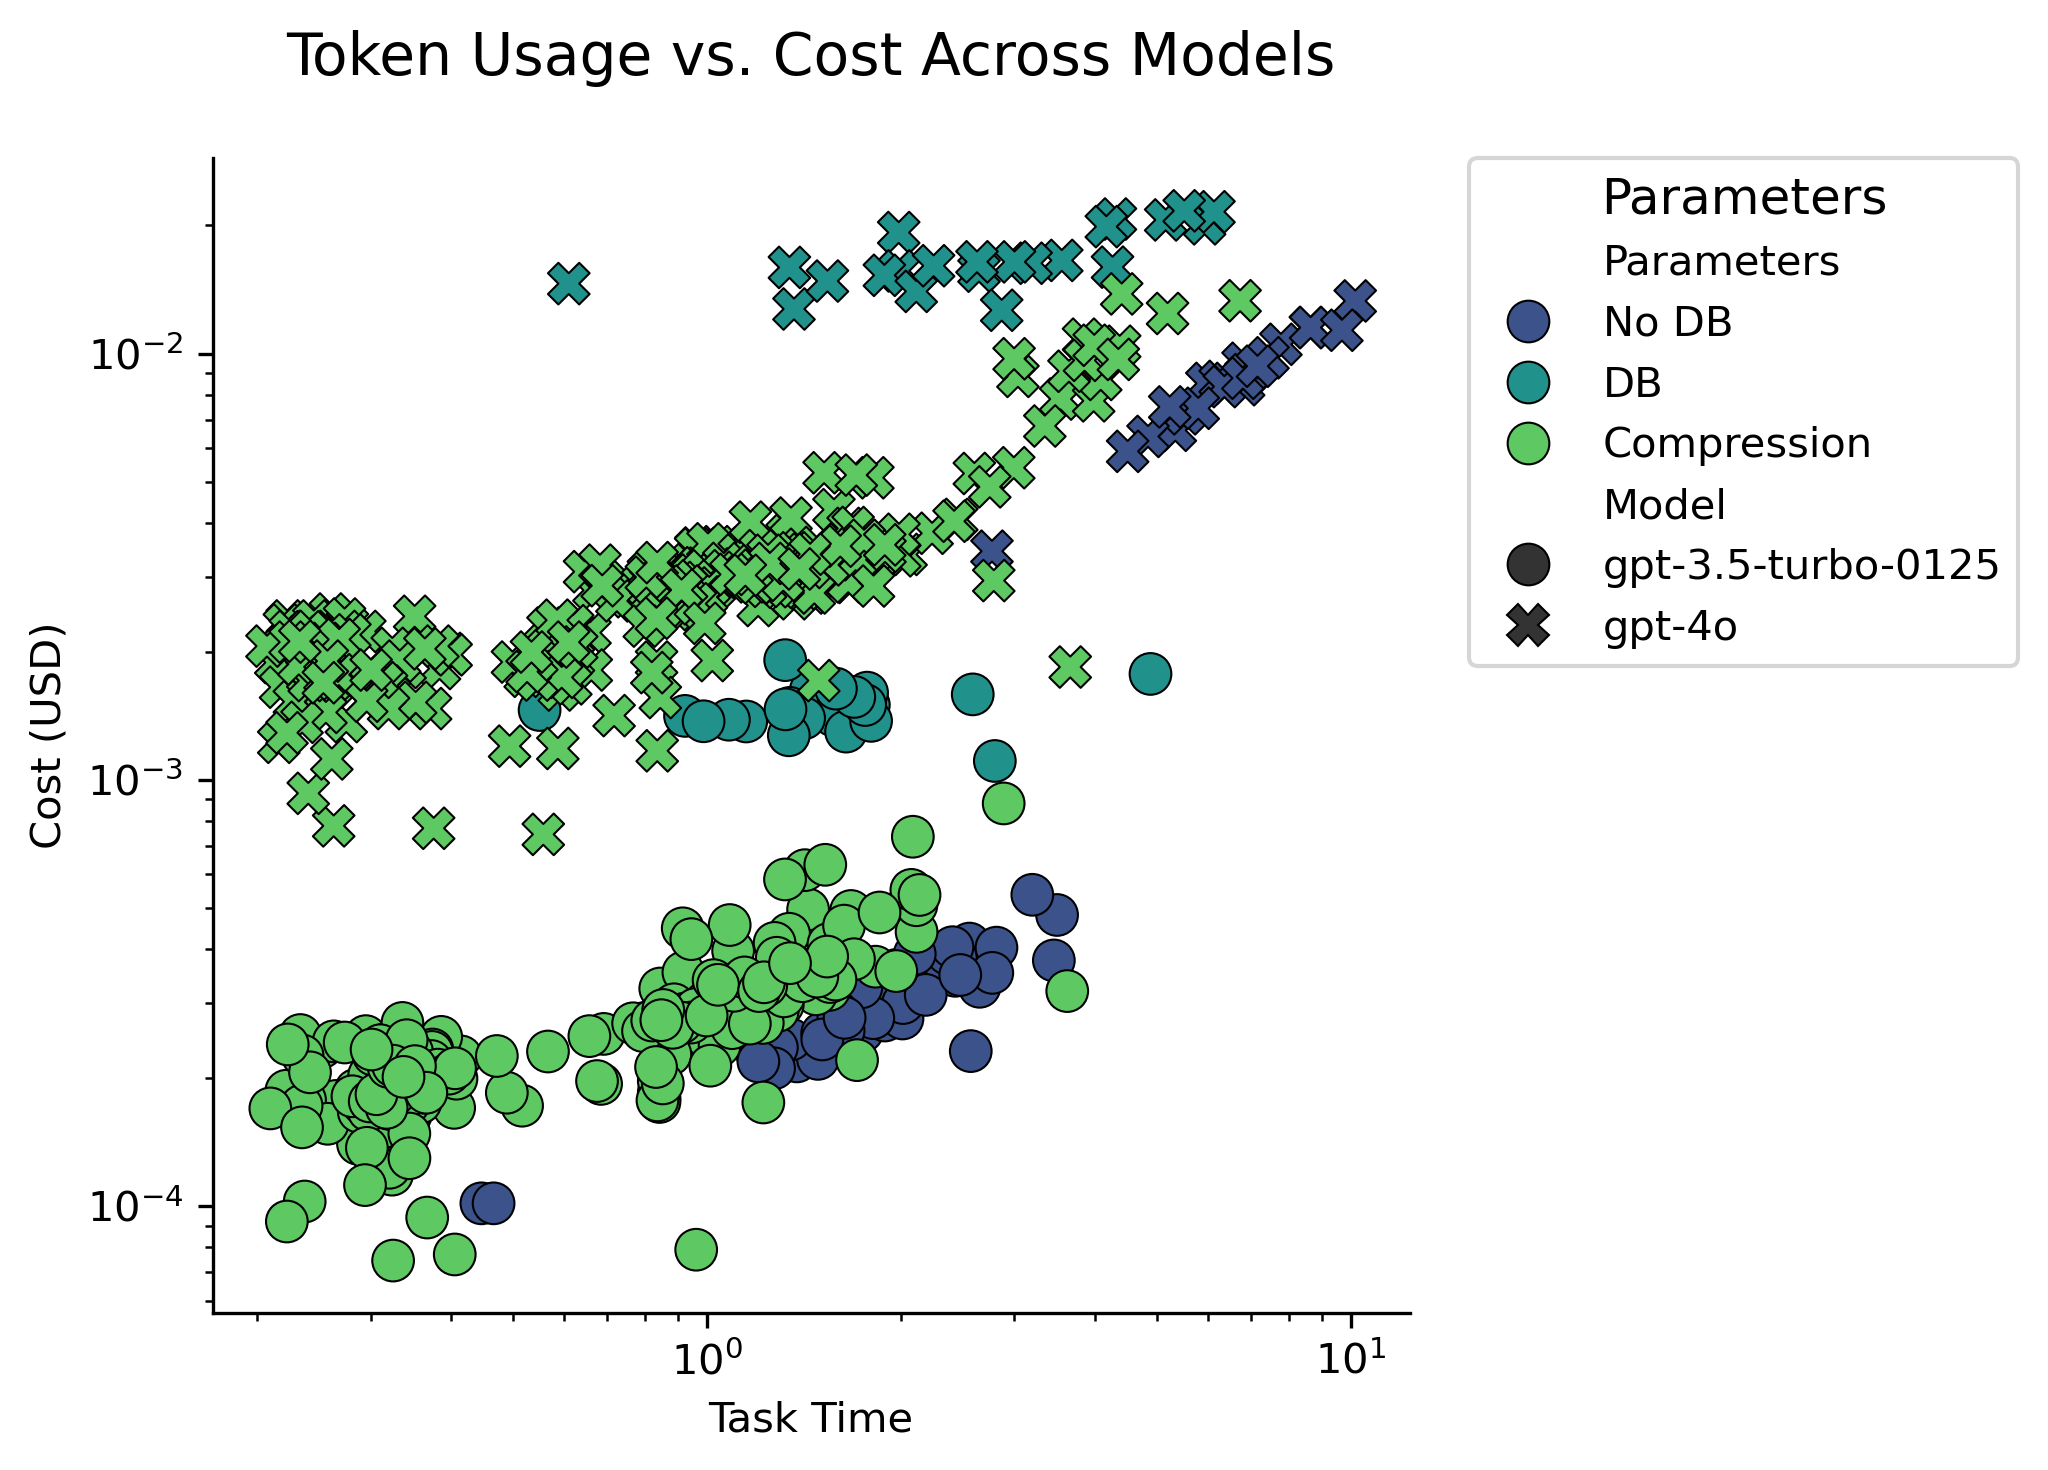

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and DPI for high resolution
plt.figure(figsize=(7, 5), dpi=300)

# Create the scatter plot
scatter = sns.scatterplot(data=log_df,
                          x='Task Time',
                          y='Cost (USD)',
                          style='Model',
                          hue='Parameters',
                          s=100,           # Set the marker size
                          palette='viridis',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

# Use logarithmic scale for both axes
plt.yscale('log')
plt.xscale('log')

# Customize axis labels
# plt.xlabel('Input Tokens', fontsize=12)
# plt.ylabel('Cost (USD)', fontsize=12)

# Add a title (optional) and remove if not needed
plt.title('Token Usage vs. Cost Across Models', fontsize=14, pad=20)

# Adjust legend settings for better readability
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10, title_fontsize=12)

# Despine for a cleaner look
sns.despine()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


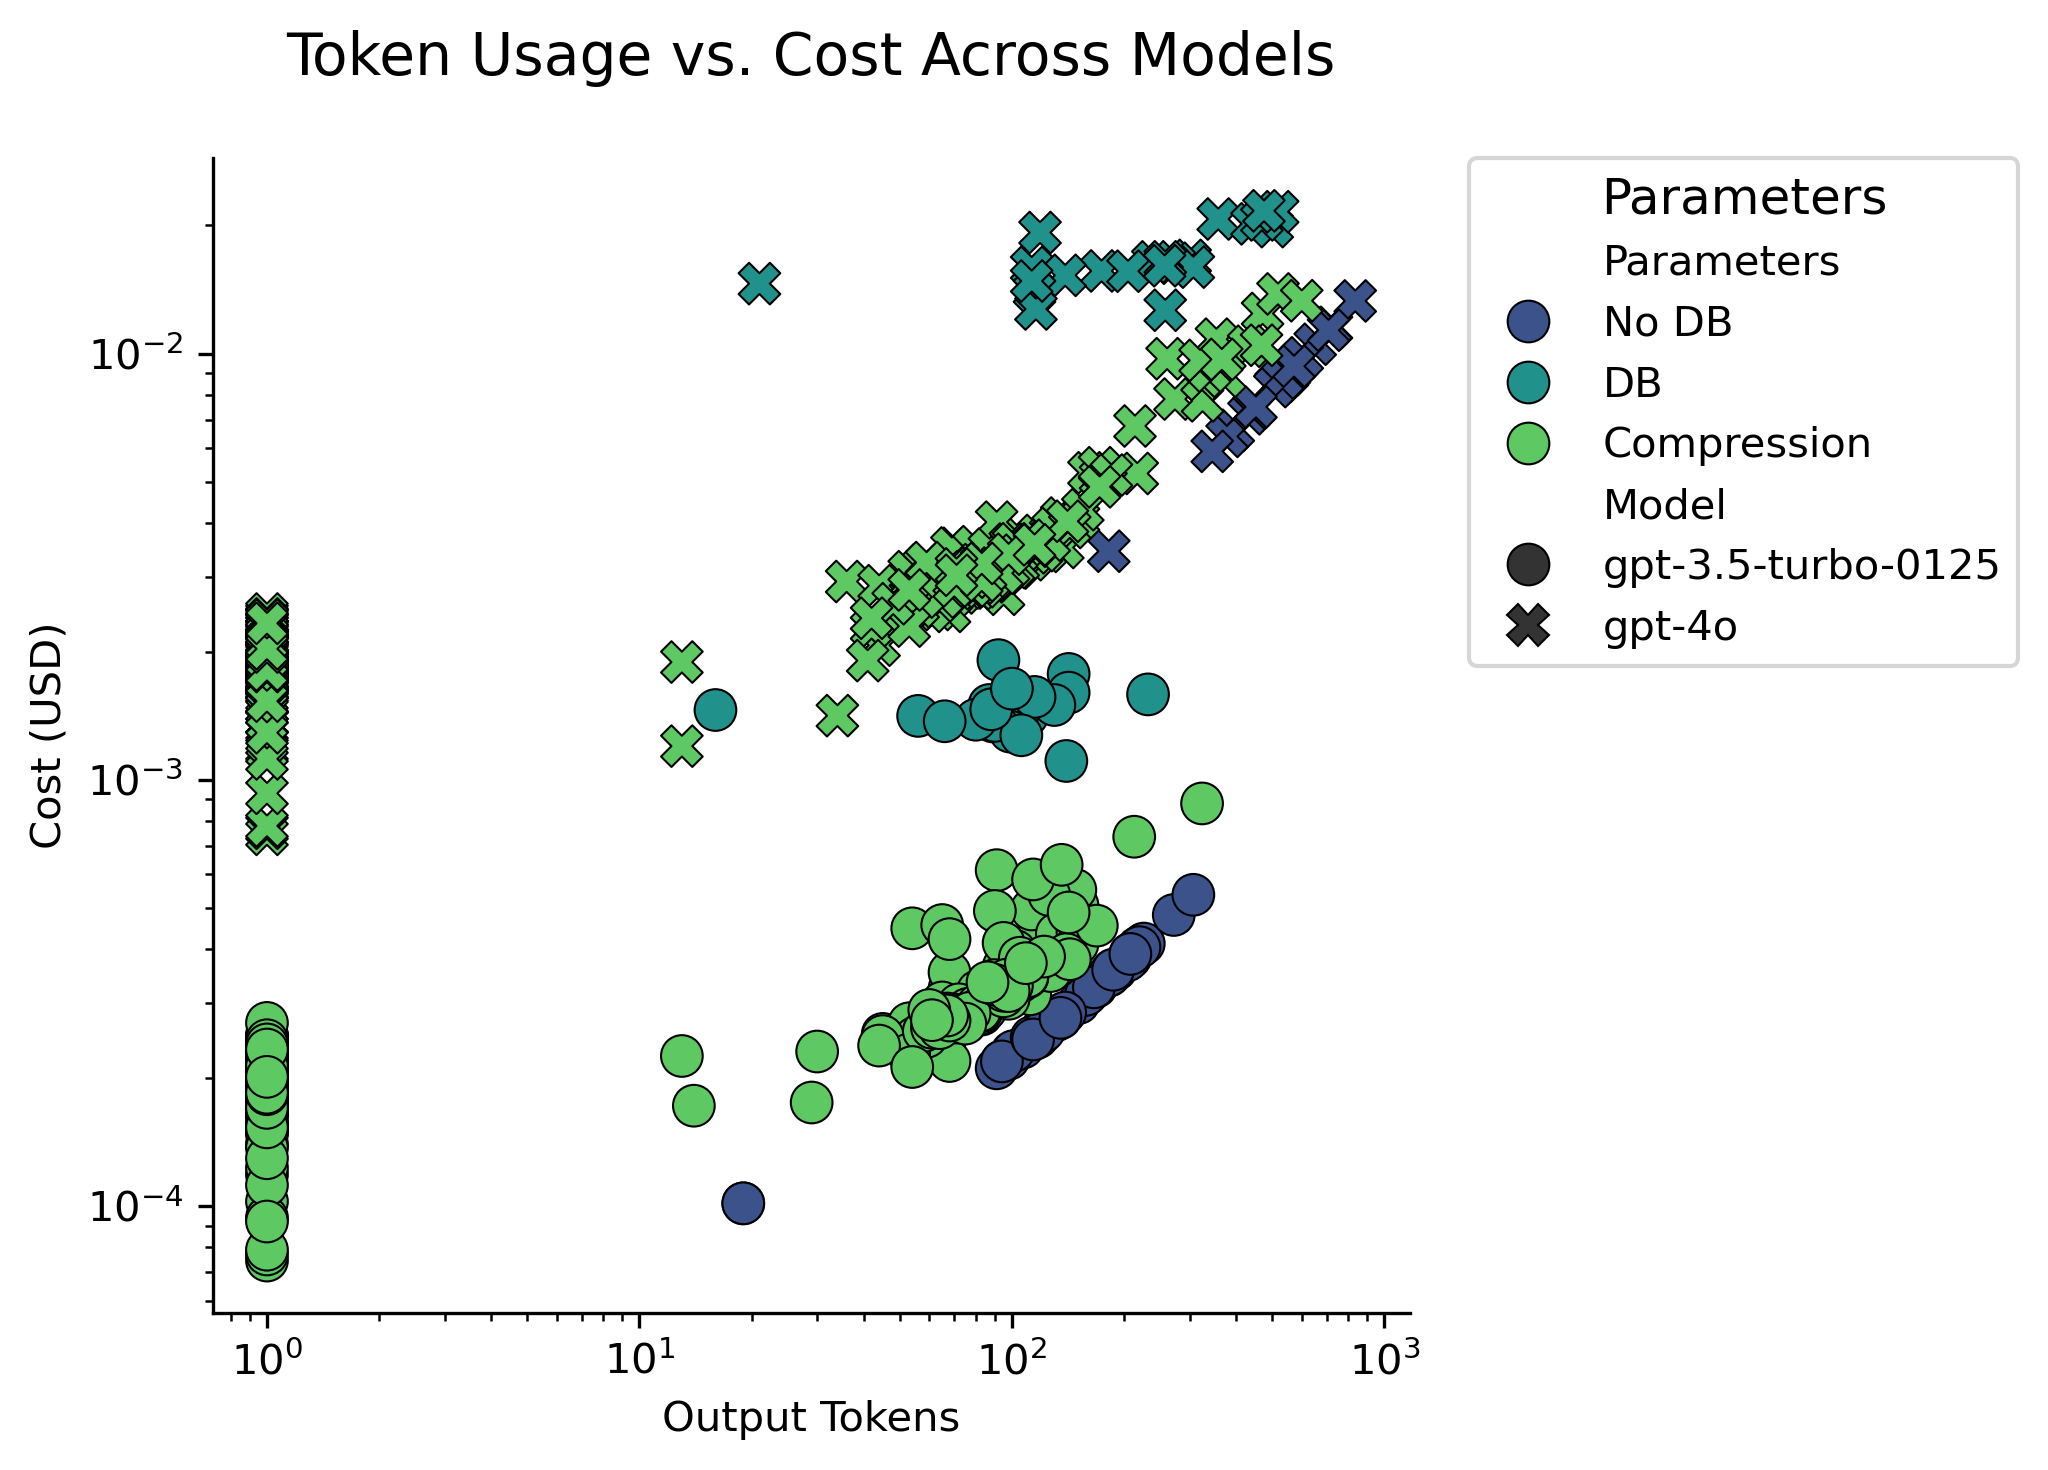

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and DPI for high resolution
plt.figure(figsize=(7, 5), dpi=300)

# Create the scatter plot
scatter = sns.scatterplot(data=log_df,
                          x='Output Tokens',
                          y='Cost (USD)',
                          style='Model',
                          hue='Parameters',
                          s=100,           # Set the marker size
                          palette='viridis',  # Use a color palette
                          edgecolor='black',  # Add a black edge to the markers
                          linewidth=0.5)

# Use logarithmic scale for both axes
plt.yscale('log')
plt.xscale('log')

# Customize axis labels
# plt.xlabel('Input Tokens', fontsize=12)
# plt.ylabel('Cost (USD)', fontsize=12)

# Add a title (optional) and remove if not needed
plt.title('Token Usage vs. Cost Across Models', fontsize=14, pad=20)

# Adjust legend settings for better readability
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10, title_fontsize=12)

# Despine for a cleaner look
sns.despine()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


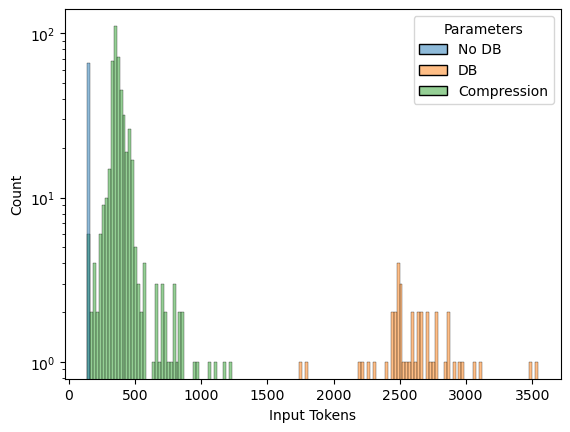

In [120]:
sns.histplot(data=log_df,
             x='Input Tokens',
             hue='Parameters')
plt.yscale('log')

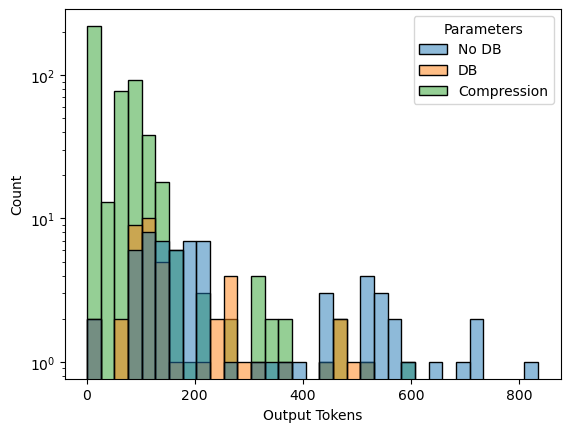

In [121]:
sns.histplot(data=log_df,
             x='Output Tokens',
             hue='Parameters')
plt.yscale('log')

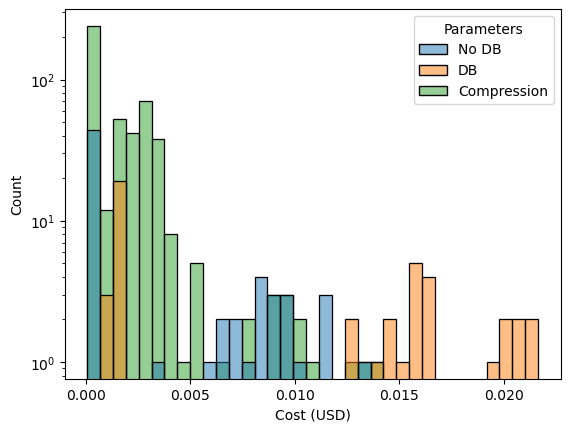

In [122]:
sns.histplot(data=log_df,
             x='Cost (USD)',
             hue='Parameters')
plt.yscale('log')

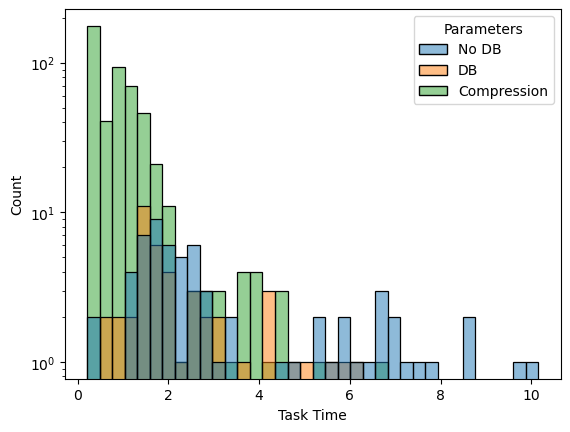

In [119]:
sns.histplot(data=log_df,
             x='Task Time',
             hue='Parameters')
plt.yscale('log')

In [90]:
ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id')[0])

SyntaxError: unterminated string literal (detected at line 1) (<unknown>, line 1)

In [97]:
step['output'].split('response_metadata=')[1].split(' id=')[0]

'{\'role\': \'assistant\', \'content\': "The text does not directly address the user\'s query about the relationship between Morse theory and the number of critical points in a Morse function on a manifold. However, it mentions that Theorem A does not provide an overall estimate of the number of critical points, and that Morse and Lyusternik and Schnirelmann developed ideas in the 1920s that address this direction.\\n\\nIn summary, the text does not provide a direct answer to the user\'s query, but hints that Morse theory is related to estimating the number of critical points, and that Morse and others made contributions to this area of study.", \'token_usage\': {\'prompt_tokens\': 353, \'total_tokens\': 476, \'completion_tokens\': 123}, \'model_name\': \'meta/llama3-70b-instruct\', \'time\': 1.961771011352539, \'call back\': {\'Total Tokens\': 476, \'Prompt Tokens\': 353, \'Completion Tokens\': 123, \'Total Cost (USD)\': 0.0}}'

In [80]:
step['output']

"content='Affinity maturation of B cells occurs in germinal centers, which are clusters of B cells that form in secondary lymphoid organs during infection or immunization. Founder clones compete based on affinity, leading to a focusing of the repertoire on the most successful progeny. The extent of homogenizing selection during normal immunization or infection is difficult to determine due to technical limitations in measuring clonal diversity within individual germinal centers.' response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 347, 'total_tokens': 432, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None, 'time': 1.2550840377807617, 'call back': {'Total Tokens': 432, 'Prompt Tokens': 347, 'Completion Tokens': 85, 'Total Cost (USD)': 0.000301}} id='run-2245cbd5-da70-49e2-8c30-9a892b2be621-0' usage_metadata={'input_tokens': 347, 'output_tokens': 85, 'to

In [86]:
ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id')[0])

{'token_usage': {'completion_tokens': 85,
  'prompt_tokens': 347,
  'total_tokens': 432,
  'completion_tokens_details': {'reasoning_tokens': 0}},
 'model_name': 'gpt-3.5-turbo-0125',
 'system_fingerprint': None,
 'finish_reason': 'stop',
 'logprobs': None,
 'time': 1.2550840377807617,
 'call back': {'Total Tokens': 432,
  'Prompt Tokens': 347,
  'Completion Tokens': 85,
  'Total Cost (USD)': 0.000301}}

In [83]:
ast.literal_eval(step['output'].split('response_metadata=')[1])

SyntaxError: invalid syntax (<unknown>, line 1)

In [87]:
log_task_time  = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id')[0])['time']
log_in_tokens  = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id')[0])['call back']['Prompt Tokens']
log_out_tokens = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id')[0])['call back']['Completion Tokens']
log_usd_cost   = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id')[0])['call back']['Total Cost (USD)']
print(f"{log_task_time =}")
print(f"{log_in_tokens =}")
print(f"{log_out_tokens=}")
print(f"{log_usd_cost  =}")

log_task_time =1.2550840377807617
log_in_tokens =347
log_out_tokens=85
log_usd_cost  =0.000301


<Axes: xlabel='Input Tokens', ylabel='Cost (USD)'>

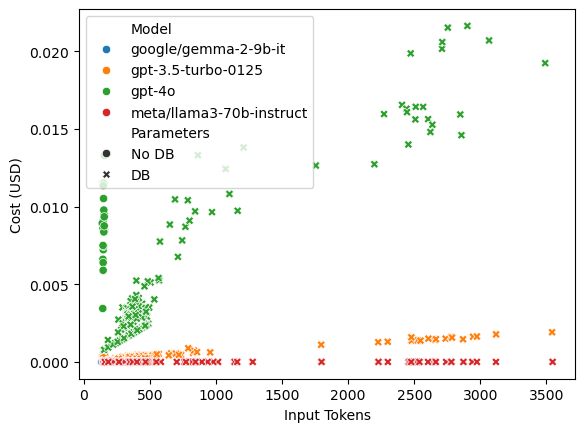

In [106]:
sns.scatterplot(
    data=log_df,
    x = 'Input Tokens',
    y = 'Cost (USD)',
    hue = 'Model',
    style = 'Parameters'
)

<Axes: xlabel='Total Time', ylabel='Count'>

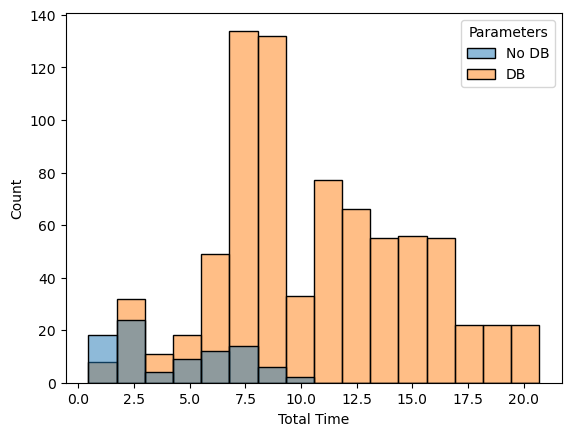

In [99]:
sns.histplot(
    data=log_df,
    x = 'Total Time',
    hue = 'Parameters')

<Axes: xlabel='Output Tokens', ylabel='Count'>

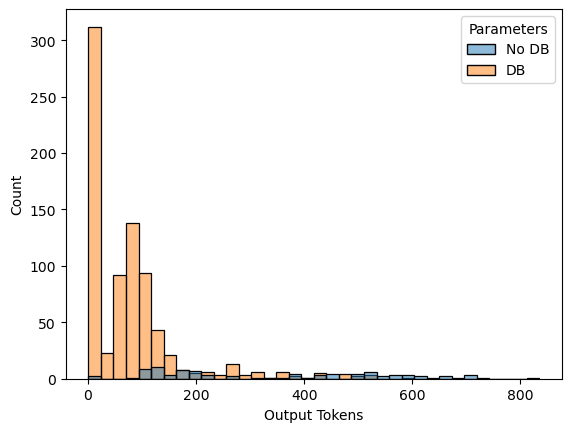

In [100]:
sns.histplot(
    data=log_df,
    x = 'Output Tokens',
    hue = 'Parameters')

<Axes: xlabel='Input Tokens', ylabel='Output Tokens'>

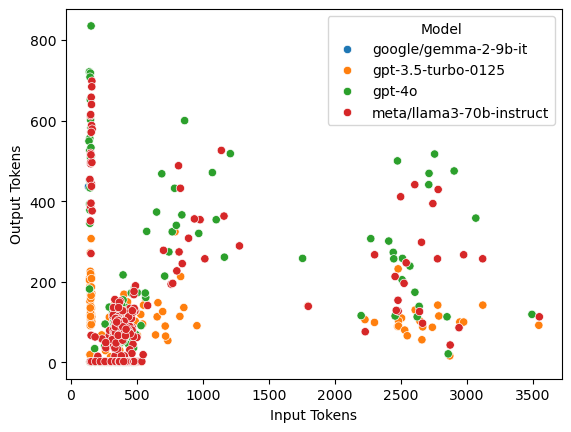

In [101]:
sns.scatterplot(data = log_df,
    x = 'Input Tokens',
    y = 'Output Tokens',
    hue = 'Model')

In [62]:
prompt_log

{'time': 'Sun Sep 22 17:18:41 2024',
 'elapsed time': 7.398444890975952,
 'prompt': 'Look this up for me in the ENRICHR database: RBL1, CDK2, CCNB1, BAX, CCND1, CHEK1, CUL3, IGF1R, RRM2, TCF7.',
 'output': 'The following table was generated by quering the gene list against GO_Biological_Process_2021:',
 'process': {'module': 'DATABASE',
  'steps': [{'llm': "model='meta/llama-3.1-405b-instruct'",
    'memory': 'None',
    'prompt': "input_variables=['history', 'input'] template='Current conversation:\\n{history}\\n    \\nGENEONTOLOGY: The Gene Ontology (GO) is an initiative to unify the representation of gene and gene product attributes across all species via the aims: 1) maintain and develop its controlled vocabulary of gene and gene product attributes; 2) annotate genes and gene products, and assimilate and disseminate annotation data; and 3) provide tools for easy access to all aspects of the data provided by the project, and to enable functional interpretation of experimental data u

In [65]:
# Loop through the log file entries
for entry_key in logFile.keys():
    # print(entry_key)
    prompt_log = logFile[entry_key]
    prompt_log_str = str(prompt_log)

    # Find the model in the log entry
    log_model = next((m for m in models if m in prompt_log_str), None)
    if log_model is None:
        continue

    # Extract module information
    log_module = prompt_log['process']['module']
    if log_module == 'RAG':
        print(prompt_log['elapsed time'])
#    log_total_time = promptLog['elapsed time']

4.9666852951049805
1.510716438293457
2.0001003742218018
2.1567158699035645
2.5553646087646484
2.6504228115081787
1.7437691688537598
1.889314889907837
1.3797390460968018
1.6953036785125732
2.4346923828125
2.4299538135528564
1.194793939590454
0.4475524425506592
1.8209071159362793
2.817197799682617
2.3589932918548584
1.4879143238067627
2.012350082397461
1.3510477542877197
2.3640265464782715
1.2853589057922363
1.2724385261535645
2.016057014465332
1.8116612434387207
2.5672380924224854
3.4950947761535645
2.404693841934204
1.6210615634918213
2.185349225997925
1.2015180587768555
2.772649049758911
3.455087900161743
2.472654104232788
1.51705002784729
0.46658778190612793
1.736459732055664
3.1989777088165283
1.9721951484680176
1.509324550628662
1.5962393283843994
1.6296288967132568
2.1011452674865723
1.5099880695343018
1.635446310043335
14.888371706008911
2.5890283584594727
2.2527987957000732
2.385474681854248
2.828477382659912
2.6416661739349365
2.0221354961395264
1.8217957019805908
2.24030494689

In [57]:
log_tasktime = ast.literal_eval(step['output'])['metadata']['time']
log_intokens = ast.literal_eval(step['output'])['metadata']['call back']['Prompt Tokens']
log_outtokens = ast.literal_eval(step['output'])['metadata']['call back']['Completion Tokens']
log_usdCost = log_intokens = ast.literal_eval(step['output'])['metadata']['call back']['Total Cost (USD)']



{'content': {Ellipsis},
 'time': 4.880276679992676,
 'call back': {'Total Tokens': 3261,
  'Prompt Tokens': 3119,
  'Completion Tokens': 142,
  'Total Cost (USD)': 0.0017725000000000002}}

In [15]:
model     = [] # what LLM?
module    = [] # what module in BRAD?
totaltime = [] # total time for module
params    = [] # what parameters for module?
task      = [] # what task / purpose in module?
tasktime  = [] # how long to complete single event?
inTokens  = [] # how many tokens in?
outTokens = [] # how many tokens out?
usdCost   = [] # how much it cost?

for i in logFile.keys():
    promptLog = logFile[i]
    prompt_log_str = str(promptLog)
    log_model = next((model for model in models if model in prompt_log_str), None)
    if log_model is None:
        continue
    log_module = promptLog['process']['module']
    log_totaltime = log_module['elapsed time']
    if log_module == 'RAG':
        for step in promptLog['process']['steps']:
            if step['purpose'] == 'chat without RAG':
                log_params = "No DB"
                output_dict = ast.literal_eval(promptLog['process']['steps'][0]['output'])
                log_tasktime = output_dict['time']
                log_intokens = output_dict['time']['call back']['Prompt Tokens']
                log_outtokens = output_dict['time']['call back']['Completion Tokens']
                log_usdCost = output_dict['time']['call back']['Total Cost (USD)']

                model.append(log_model)
                totaltime.append(log_totaltime)
                module.append(log_module)
                params.append(log_params)
                task.append("QA with empty database")
                time.append(log_tasktime)
                inTokens.append(log_intokens)
                outTokens.append(log_outtokens)
                usdCost.append(log_usdCost)


In [36]:
output_dict

{'content': '```python\nimport datetime\n\n# Get the current date and time\nnow = datetime.datetime.now()\n\n# Format the date and time string\ntimestamp = now.strftime("%Y-%m-%d_%H-%M-%S")\n\n# Create the log file name\nlog_file_name = f"log_{timestamp}.txt"\n\n# Open the log file in write mode\nwith open(log_file_name, "w") as log_file:\n    # Write the initial log message\n    log_file.write(f"Log file started at {timestamp}\\n")\n\nprint(f"Log file \'{log_file_name}\' created successfully.")\n```\n\n**Explanation:**\n\n1. **Import `datetime`:** This line imports the `datetime` module, which provides functions for working with dates and times.\n2. **Get current date and time:** `datetime.datetime.now()` returns the current date and time as a `datetime` object.\n3. **Format timestamp:** `strftime("%Y-%m-%d_%H-%M-%S")` formats the `datetime` object into a string in the format "YYYY-MM-DD_HH-MM-SS".\n4. **Create log file name:**  `f"log_{timestamp}.txt"` creates a filename using an f-s

In [31]:
data = promptLog['process']['steps'][0]['output']
data

'{\'content\': \'```python\\nimport datetime\\n\\n# Get the current date and time\\nnow = datetime.datetime.now()\\n\\n# Format the date and time string\\ntimestamp = now.strftime("%Y-%m-%d_%H-%M-%S")\\n\\n# Create the log file name\\nlog_file_name = f"log_{timestamp}.txt"\\n\\n# Open the log file in write mode\\nwith open(log_file_name, "w") as log_file:\\n    # Write the initial log message\\n    log_file.write(f"Log file started at {timestamp}\\\\n")\\n\\nprint(f"Log file \\\'{log_file_name}\\\' created successfully.")\\n```\\n\\n**Explanation:**\\n\\n1. **Import `datetime`:** This line imports the `datetime` module, which provides functions for working with dates and times.\\n2. **Get current date and time:** `datetime.datetime.now()` returns the current date and time as a `datetime` object.\\n3. **Format timestamp:** `strftime("%Y-%m-%d_%H-%M-%S")` formats the `datetime` object into a string in the format "YYYY-MM-DD_HH-MM-SS".\\n4. **Create log file name:**  `f"log_{timestamp}.tx

In [34]:
import ast

xx = ast.literal_eval(data)
type(xx)

dict

In [24]:
promptLog['process']['steps']

[{'llm': "model='google/gemma-2-9b-it'",
  'memory': 'None',
  'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'",
  'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: First call to make a log file',
  'output': '{\'content\': \'```python\\nimport datetime\\n\\n# Get the current date and time\\nnow = datetime.datetime.now()\\n\\n# Format the date and time string\\ntimestamp = now.strftime("%Y-%m-%d

In [9]:
str(promptLog)

models = ['gpt-3.5-turbo-0125',
          'gpt-4o',
          'meta/llama3-70b-instruct',
          'meta/llama-3.1-405b-instruct',
          'mistralai/mistral-large-2-instruct',
          'nvidia/nemotron-4-340b-instruct',
          'google/gemma-2-9b-it']

{'time': 'Sun Sep 22 17:18:41 2024',
 'elapsed time': 7.398444890975952,
 'prompt': 'Look this up for me in the ENRICHR database: RBL1, CDK2, CCNB1, BAX, CCND1, CHEK1, CUL3, IGF1R, RRM2, TCF7.',
 'output': 'The following table was generated by quering the gene list against GO_Biological_Process_2021:',
 'process': {'module': 'DATABASE',
  'steps': [{'llm': "model='meta/llama-3.1-405b-instruct'",
    'memory': 'None',
    'prompt': "input_variables=['history', 'input'] template='Current conversation:\\n{history}\\n    \\nGENEONTOLOGY: The Gene Ontology (GO) is an initiative to unify the representation of gene and gene product attributes across all species via the aims: 1) maintain and develop its controlled vocabulary of gene and gene product attributes; 2) annotate genes and gene products, and assimilate and disseminate annotation data; and 3) provide tools for easy access to all aspects of the data provided by the project, and to enable functional interpretation of experimental data u